## Base Imports

In [18]:
import datetime
from pathlib import Path
from typing import Dict, List, Union
import warnings
warnings.filterwarnings("ignore")
import itertools

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

In [19]:
def load_data(locus_weights_path: Union[str, Path],
              temperature_path: Union[str, Path],
              locus_group_matching_path: Union[str, Path],
              fresh_water_dates_path: Union[str, Path],
              sw_fw_matching_path: Union[str, Path],
              sw_fw_matching_path_with_cnt: Union[str, Path],
              final_locus_weighted_path: Union[str, Path],
              mortality_path: Union[str, Path]) -> Dict[str, pd.DataFrame]:
    
    locus_weights = pd.read_csv(locus_weights_path)
    locus_weights.starttime = pd.to_datetime(locus_weights.starttime, format=TIME_FORMAT)
    locus_weights.endtime = pd.to_datetime(locus_weights.endtime, format=TIME_FORMAT)
    
    temperature = pd.read_csv(temperature_path)
#     temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
#     temperature.locus_group_id=temperature.locus_group_id.astype(INT_TYPE)
#     temperature['event_year'] = temperature['event_date'].dt.year

    locus_group_matching = pd.read_csv(locus_group_matching_path)
    locus_group_matching = locus_group_matching.astype(INT_TYPE)

    fresh_water_dates = pd.read_csv(fresh_water_dates_path)
    for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
        fresh_water_dates[d] = pd.to_datetime(fresh_water_dates[d], format=TIME_FORMAT)

    sw_fw_matching = pd.read_csv(sw_fw_matching_path)
    sw_fw_matching_with_cnt = pd.read_csv(sw_fw_matching_path_with_cnt)

    sw_fw_cols = ['target_seawater_locus_id',
                  'transport_date',
                  'ponding_date',
                  'pretransfer_fw_locus_population_id',
                  'fish_count_shipped_out',
                  'avg_weight_g_stocked']
    sw_fw_matching = sw_fw_matching[sw_fw_matching.origin_site_type == 'Freshwater'][sw_fw_cols]
    sw_fw_matching.pretransfer_fw_locus_population_id = sw_fw_matching.\
    pretransfer_fw_locus_population_id.astype(INT_TYPE)

    final_locus_weighted = pd.read_csv(final_locus_weighted_path)
    final_locus_weighted.event_date = pd.to_datetime(final_locus_weighted.event_date)

    mortality = pd.read_csv(mortality_path)
    mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
    mortality['transport_year']= mortality['transfer_date'].dt.year


    dataframes = {
        'temperature': temperature,
        'locus_weigts': locus_weights,
        'locus_group_matching': locus_group_matching,
        'final_locus_weighted': final_locus_weighted,
        'fresh_water_dates': fresh_water_dates,
        'sw_fw_matching': sw_fw_matching,
        'sw_fw_matching_with_cnt': sw_fw_matching_with_cnt,
        'mortality': mortality
    }
    
    return dataframes

def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum

def create_factors_df(agg_ph_df, factors, key_columns, weight_column, weighted_func):
    """Creates factors df on key_columns level using weight_column to calculate weighted average"""
    factors_dfs = []
    print('Weighting factors')
    for factor in tqdm(factors):
        tmp = agg_ph_df.groupby(key_columns).apply(weighted_func, weight_column, factor).reset_index().rename(columns={0: factor})
        factors_dfs.append(tmp)

    factor_df = factors_dfs[0]
    for df in factors_dfs[1:]:
        factor_df = factor_df.merge(df, on=key_columns, how='inner')
    return factor_df

def plot_factors(factors_df, path):
    pairplot = sns.pairplot(factors_df[np.append(corr_df.index, 'mortality')], size=(20, 15))
    plt.title('Mortality vs feature pairplot')
    plt.show()

    for ax in pairplot.axes.flatten():
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation=0)
        # set y labels alignment
        ax.xaxis.get_label().set_horizontalalignment('right')
        ax.yaxis.get_label().set_horizontalalignment('right')
    pairplot.figure.savefig(path / 'mortality_vs_feature_pairplot.jpg')

def plot_swarm(df, factor, target, bins, y_scale=1):
    sns.set_style("whitegrid")

    arr_for_chart = df.copy()
    arr_for_chart[factor+'_binned'] = pd.cut(df[factor], bins=bins)
    arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100
    x_axis_factor = factor + '_binned'

    plt.figure()
    f, axs = plt.subplots(1, 1, figsize=(18,8), sharex=True)
    box_plot = sns.swarmplot(data=arr_for_chart, x=x_axis_factor, y=target)

    mean_target = arr_for_chart.groupby(x_axis_factor)[target].mean()
    mean_main_factor = arr_for_chart.groupby(x_axis_factor)[factor].mean()

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,
                      mean_target.iloc[xtick],
                      round(mean_target.iloc[xtick], 2),
                      horizontalalignment='center',
                      size='xx-large',
                      color='black',
                      weight='semibold')
        box_plot.text(xtick,
                      mean_main_factor.iloc[xtick] / y_scale,
                      round(mean_main_factor.iloc[xtick], 2),
                      horizontalalignment='center',
                      size='xx-large',
                      color='darkblue',
                      weight='semibold')
    
    plt.title(f'Swarmplot: {target} vs. {factor}')
    axs.legend(
        arr_for_chart[x_axis_factor].value_counts().sort_index().apply(lambda x: 'Sample count: ' + str(x)),
        loc='upper right'
    )

    f.show()

#     f.savefig(f'Visualisation\\swarmplot_{target}_vs_{factor}.jpg')

In [20]:
def plot_swarm_test(df, factor, factor_pair, target, bins, y_scale=1):
    sns.set_style("whitegrid")

    arr_for_chart = df.copy()
    arr_for_chart[factor+'_binned'] = pd.cut(df[factor], bins=bins)
    arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100
    x_axis_factor = factor + '_binned'

    plt.figure()
    f, axs = plt.subplots(1, 1, figsize=(18,8), sharex=True)
    box_plot = sns.swarmplot(data=arr_for_chart, x=x_axis_factor, y=target)

    mean_target = arr_for_chart.groupby(x_axis_factor)[target].mean()
    factor_pair = arr_for_chart.groupby(x_axis_factor)[factor_pair].mean()

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,
                      mean_target.iloc[xtick],
                      round(mean_target.iloc[xtick], 2),
                      horizontalalignment='center',
                      size='xx-large',
                      color='black',
                      weight='semibold')
        box_plot.text(xtick,
                      factor_pair.iloc[xtick] / y_scale,
                      round(factor_pair.iloc[xtick], 2),
                      horizontalalignment='center',
                      size='xx-large',
                      color='darkblue',
                      weight='semibold')
    
    plt.title(f'Swarmplot: {target} vs. {factor}')
    axs.legend(
        arr_for_chart[x_axis_factor].value_counts().sort_index().apply(lambda x: 'Sample count: ' + str(x)),
        loc='upper right'
    )

    f.show()

#     f.savefig(f'Visualisation\\swarmplot_{target}_vs_{factor}.jpg')

In [21]:
dataframes = load_data(locus_weights_path='../data/evt_movement_ratio_with_dates.csv',
                       temperature_path='../data/FW_temperature_cleared.csv',
                       locus_group_matching_path='../data/locus_locus_group_matching.csv',
                       fresh_water_dates_path='../data/FW_cycle_dates.csv',
                       sw_fw_matching_path='../data/seawater_freshwater_matching.csv',
                       sw_fw_matching_path_with_cnt='../data/sw_locus_fw_locus_population_with_counts.csv',
                       final_locus_weighted_path='../data/lw_alldates_final.csv',
                       mortality_path='../data/smolt_dataset_transfers.csv')

temperature = dataframes['temperature']
locus_weights = dataframes['locus_weigts']
locus_group_matching = dataframes['locus_group_matching']
final_locus_weighted = dataframes['final_locus_weighted']
fresh_water_dates = dataframes['fresh_water_dates']
sw_fw_matching = dataframes['sw_fw_matching']
mortality = dataframes['mortality']
sw_fw_matching_with_cnt = dataframes['sw_fw_matching_with_cnt']

#tgc = pd.read_csv('data/transfers_until2023Feb28_with_sw_growth_targets.csv')
vaccines = pd.read_csv('../data/vaccines_with_final_locus_population_id.csv')
vaccines['VAC_EVENT_DATE'] = pd.to_datetime(vaccines['VAC_EVENT_DATE'] , format=TIME_FORMAT)
vaccines_agg = vaccines.groupby('FINAL_LOCUS_POPULATION_ID')[['VAC_EVENT_DATE', 'VAC_WEIGHT']].mean(numeric_only=False)
fresh_water_dates.rename(columns={'pretransfer_fw_locus_population_id': 'final_locus_population_id'}, inplace=True)
sw_fw_matching.transport_date = pd.to_datetime(sw_fw_matching.transport_date, format=TIME_FORMAT)
sw_fw_matching_with_cnt.transfer_date = pd.to_datetime(sw_fw_matching_with_cnt['transfer_date'], format=TIME_FORMAT)
sw_fw_matching_with_cnt['transfer_year'] = sw_fw_matching_with_cnt['transfer_date'].dt.year

In [22]:
tempearture_mean = pd.DataFrame(temperature.groupby('final_locus_population_id')['temperature_cleared'].mean())\
.rename(columns={'temperature_cleared':'temperature_mean'})

temperature = temperature.merge(tempearture_mean,
                  left_on='final_locus_population_id', 
                  right_index=True)

In [24]:
fresh_water_dates

,final_locus_population_id,pretransfer_fw_locus_id,first_movement_date,first_feeding_date,shipout_date
0,36687326,3048734,2006-11-26,2006-11-27,2007-04-13
1,36687382,3046776,2006-11-26,2006-11-27,2007-03-28
2,36687957,3046922,2006-11-26,2006-11-27,2007-04-11
3,36688302,3050804,2006-11-26,2006-11-27,2007-04-19
4,36688439,3047106,2006-11-26,2006-11-27,2007-04-23
...,...,...,...,...,...
5885,194762602,3050045,2022-11-09,2023-03-24,2024-01-02
5886,194762603,3050045,2022-11-09,2023-03-24,2024-01-02
5887,194762605,3050895,2022-11-09,2023-03-24,2024-01-02
5888,194762609,3050045,2022-11-09,2023-03-24,2024-01-02


## Feed Data

In [25]:
class FeedFactorsCalculator:
    """Calculates numeric feed factors such as FCR, SGR, SFR"""

    @staticmethod
    def calculate_fcr(sum_feed: np.ndarray,
                      fish_count_end: np.ndarray,
                      average_weight_end: np.ndarray,
                      fish_count_start: np.ndarray,
                      average_weight_start: np.ndarray):
        return (1000 * sum_feed) / (fish_count_end * average_weight_end - fish_count_start * average_weight_start)

    @staticmethod
    def calculate_sgr(average_weight_end: np.ndarray, average_weight_start: np.ndarray, period_len: np.ndarray):
        return 100 * ((average_weight_end / average_weight_start) ** (1 / period_len) - 1)

    @staticmethod
    def calculate_sfr(fcr: np.ndarray, sgr: np.ndarray):
        return fcr * sgr
    
    def calculate_factors(self,
                          start_period_name: str,
                          start_df: pd.DataFrame,
                          end_period_name: str,
                          end_df: pd.DataFrame):        
        fish_count_end = end_df['close_count'].values
        fish_count_start = start_df['close_count'].values
        
        average_weight_end = end_df['close_weight_g'].values
        average_weight_start = start_df['close_weight_g'].values
        
        sum_feed_end = end_df[f'{start_period_name}-{end_period_name}-sum'].values
        sum_feed_start = start_df[f'{start_period_name}-{end_period_name}-sum'].values
        assert (sum_feed_end == sum_feed_start).all()
        sum_feed = sum_feed_end
        
        period_len_end = end_df[f'{start_period_name}-{end_period_name}-len'].values
        period_len_start = start_df[f'{start_period_name}-{end_period_name}-len'].values
        assert (period_len_end == period_len_start).all()
        period_len = period_len_end

        fcr = self.calculate_fcr(sum_feed, fish_count_end, average_weight_end, fish_count_start, average_weight_start)
        sgr = self.calculate_sgr(average_weight_end, average_weight_start, period_len)
        sfr = fcr * sgr

        return fcr, sgr, sfr

    def get_period_len(self,
                       df: pd.DataFrame,
                       period_end_col: str,
                       period_start_col: str):
        grouped = df.groupby('final_locus_population_id').mean(numeric_only=False)
        return (grouped[period_end_col] - grouped[period_start_col]).dt.days

    def get_period_sum(self,
                       df: pd.DataFrame,
                       period_end_col=None,
                       period_start_col=None,
                       key_col=''):
        
        period = df[df['event_date'] <= df[period_end_col]]
        if period_start_col is not None:
            period = period[df['event_date'] >= df[period_start_col]]
        return period.groupby('final_locus_population_id')['amount'].sum()

    def process(self, feed_df):

        agg_df = pd.DataFrame()
        agg_df['first_feeding-transfer-len'] = self.get_period_len(feed_df, 'shipout_date', 'first_feeding_date')
        agg_df['first_feeding-transfer-len'] = self.get_period_len(feed_df, 'shipout_date', 'first_feeding_date')
        agg_df['first_feeding-vaccination-len'] = self.get_period_len(feed_df,'VAC_EVENT_DATE', 'first_feeding_date')
        agg_df['vaccination-transfer-len'] = self.get_period_len(feed_df, 'shipout_date', 'VAC_EVENT_DATE')

        agg_df['first_feeding-transfer-sum'] = self.get_period_sum(feed_df,
                                                                    'shipout_date',
                                                                    'first_feeding_date',
                                                                    'amount')
        agg_df['first_feeding-vaccination-sum'] = self.get_period_sum(feed_df,
                                                                      'VAC_EVENT_DATE',
                                                                      'first_feeding_date',
                                                                      'amount')                                                            
        agg_df['vaccination-transfer-sum'] = self.get_period_sum(feed_df,
                                                                  'shipout_date',
                                                                  'VAC_EVENT_DATE',
                                                                  'amount')     
        agg_df.reset_index(inplace=True)

        first_feeding = feed_df[feed_df['event_date'] == feed_df['first_feeding_date']].reset_index(drop=True)
        vaccination = feed_df[feed_df['event_date'] == pd.to_datetime(feed_df['VAC_EVENT_DATE'].dt.date)]\
        .reset_index(drop=True)
        transfer = feed_df[feed_df['event_date'] == feed_df['shipout_date']].reset_index(drop=True)
        
        time_periods = {
            'start': [{'name': 'first_feeding', 'data': first_feeding.merge(agg_df)}, 
                      {'name': 'first_feeding', 'data': first_feeding.merge(agg_df)},
                      {'name': 'vaccination', 'data': vaccination.merge(agg_df)}],
            'end': [{'name': 'vaccination', 'data': vaccination.merge(agg_df)}, 
                    {'name': 'transfer', 'data': transfer.merge(agg_df)},
                    {'name': 'transfer', 'data': transfer.merge(agg_df)}]
        }
        
        for start, end in zip(time_periods['start'], time_periods['end']):
            fcr, sgr, sfr = self.calculate_factors(start['name'], start['data'], end['name'], end['data'])
            agg_df[f"{start['name']}-{end['name']}-fcr"] = fcr
            agg_df[f"{start['name']}-{end['name']}-sgr"] = sgr
            agg_df[f"{start['name']}-{end['name']}-sfr"] = sfr

        return agg_df
    
feed_calc = FeedFactorsCalculator()

### Factors on FLP level

In [8]:
# feed_data_extended2 = pd.read_csv('data/feed_data_extended_unsmoothed.csv')
# feed_data_extended = pd.read_csv('data/feed_data_extended_unsmoothed_with_nan.csv')
#feed_data_extended = pd.read_csv('../data/feed_data_extended_unsmoothed_SFR_using_close.csv') #

In [9]:
# feed_data_with_dates = feed_data_extended.merge(
#     fresh_water_dates[['final_locus_population_id', 'first_feeding_date', 'shipout_date']],
#     on='final_locus_population_id',
#     how='inner',
# )

# print(f'unique flp count: {feed_data_with_dates.shape}')

# feed_data_with_dates = feed_data_with_dates.merge(
#     vaccines_agg,
#     left_on='final_locus_population_id',
#     right_on='FINAL_LOCUS_POPULATION_ID',
#     how='inner'
# )

# print(f'unique flp count: {feed_data_with_dates.shape}')

# feed_data_with_dates = feed_data_with_dates.merge(
#     sw_fw_matching_with_cnt.groupby('from_locus_population_id')[['transfer_date', 'from_avg_weight']].mean(numeric_only=False),
#     left_on='final_locus_population_id',
#     right_index=True,
#     how='inner'
# )
# print(f'unique flp count: {feed_data_with_dates.shape}')

# feed_data_with_dates['shipout_year'] = feed_data_with_dates['shipout_date'].dt.year
# feed_data_with_dates['event_date'] = pd.to_datetime(feed_data_with_dates['event_date'], format=TIME_FORMAT)
# first_feeding_feed = feed_data_with_dates[
#     feed_data_with_dates['event_date'] == feed_data_with_dates['first_feeding_date']
# ]
# first_feeding_feed = first_feeding_feed[['final_locus_population_id', 'close_weight_g', 'first_feeding_date']]
# first_feeding_feed.rename(columns={'close_weight_g': 'weight_first_feeding'}, inplace=True)

In [10]:
# feed_data_extended = pd.read_csv('./feed_data_extended_unsmoothed_upd.csv')
feed_data_extended = pd.read_csv('../data/feed_data_extended_unsmoothed.csv')

In [11]:
feed_data_extended['event_date'].max()

'2023-12-11'

In [12]:
feed_data_extended['event_date'] = pd.to_datetime(feed_data_extended['event_date'], utc=True)
fresh_water_dates['event_date'] = pd.to_datetime(fresh_water_dates['first_feeding_date'], utc=True)
temperature['event_date'] = pd.to_datetime(temperature['event_date'], utc=True)

In [13]:
feed_data_with_dates = feed_data_extended.merge(
    fresh_water_dates[['final_locus_population_id', 'first_feeding_date', 'shipout_date']],
    on='final_locus_population_id',
    how='inner',
)

feed_data_with_dates = feed_data_with_dates.merge(
    temperature[['final_locus_population_id', 'event_date', 'temperature_cleared']],
    on=['final_locus_population_id', 'event_date'],
    how='left'
)

feed_data_with_dates['temperature_cleared'].fillna(feed_data_with_dates['temperature_cleared'].mean(), inplace=True)
print(f'unique flp count: {feed_data_with_dates.shape}')


unique flp count: (323757, 13)


In [14]:

feed_data_with_dates = feed_data_with_dates.merge(
    vaccines_agg,
    left_on='final_locus_population_id',
    right_on='FINAL_LOCUS_POPULATION_ID',
    how='inner'
)

print(f'unique flp count: {feed_data_with_dates.shape}')

feed_data_with_dates = feed_data_with_dates.merge(
    sw_fw_matching_with_cnt.groupby('from_locus_population_id')[['transfer_date', 'from_avg_weight','from_count_stocking']].mean(numeric_only=False),
    left_on='final_locus_population_id',
    right_index=True,
    how='inner'
)
print(f'unique flp count: {feed_data_with_dates.shape}')


print(f'unique flp count: {feed_data_with_dates.shape}')

feed_data_with_dates['shipout_year'] = feed_data_with_dates['shipout_date'].dt.year

unique flp count: (312598, 15)
unique flp count: (312598, 18)
unique flp count: (312598, 18)


In [15]:
feed_data_with_dates[feed_data_with_dates['final_locus_population_id'] == 194761283]

,final_locus_population_id,event_date,amount,SFR,FCR,SGR,open_count,open_weight_g,close_count,close_weight_g,first_feeding_date,shipout_date,temperature_cleared,VAC_EVENT_DATE,VAC_WEIGHT,transfer_date,from_avg_weight,from_count_stocking,shipout_year
312533,194761283,2023-10-08 00:00:00+00:00,20.0,0.003214,1.010730,0.323222,77348.0,80.44,77344.0,80.70,2023-03-24,2023-12-11,12.90,2023-10-04 16:00:00,82.088129,2023-12-11,146.0,3726.0,2023
312534,194761283,2023-10-09 00:00:00+00:00,60.0,0.009613,1.025715,0.954151,77344.0,80.70,77331.0,81.47,2023-03-24,2023-12-11,13.00,2023-10-04 16:00:00,82.088129,2023-12-11,146.0,3726.0,2023
312535,194761283,2023-10-10 00:00:00+00:00,40.0,0.006349,1.041440,0.638272,77331.0,81.47,77309.0,81.99,2023-03-24,2023-12-11,12.84,2023-10-04 16:00:00,82.088129,2023-12-11,146.0,3726.0,2023
312536,194761283,2023-10-11 00:00:00+00:00,40.0,0.006311,0.997054,0.634224,77309.0,81.99,77308.0,82.51,2023-03-24,2023-12-11,12.68,2023-10-04 16:00:00,82.088129,2023-12-11,146.0,3726.0,2023
312537,194761283,2023-10-12 00:00:00+00:00,60.0,0.009481,1.009197,0.952886,77308.0,81.89,77295.0,82.67,2023-03-24,2023-12-11,12.52,2023-10-04 16:00:00,82.088129,2023-12-11,146.0,3726.0,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312593,194761283,2023-12-07 00:00:00+00:00,20.0,0.001714,0.985014,0.174014,75201.0,155.16,75201.0,155.43,2023-03-24,2023-12-11,13.80,2023-10-04 16:00:00,82.088129,2023-12-11,146.0,3726.0,2023
312594,194761283,2023-12-08 00:00:00+00:00,20.0,0.001714,0.985014,0.174014,75201.0,155.16,75201.0,155.43,2023-03-24,2023-12-11,13.10,2023-10-04 16:00:00,82.088129,2023-12-11,146.0,3726.0,2023
312595,194761283,2023-12-09 00:00:00+00:00,20.0,0.001714,0.985014,0.174014,75201.0,155.16,75201.0,155.43,2023-03-24,2023-12-11,13.50,2023-10-04 16:00:00,82.088129,2023-12-11,146.0,3726.0,2023
312596,194761283,2023-12-10 00:00:00+00:00,20.0,0.001714,0.985014,0.174014,75201.0,155.16,75201.0,155.43,2023-03-24,2023-12-11,13.80,2023-10-04 16:00:00,82.088129,2023-12-11,146.0,3726.0,2023


In [16]:
feed_data_with_dates['event_date'] = pd.to_datetime(feed_data_with_dates['event_date'], utc=True)
feed_data_with_dates['first_feeding_date'] = pd.to_datetime(feed_data_with_dates['first_feeding_date'], utc=True)
feed_data_with_dates['VAC_EVENT_DATE'] = pd.to_datetime(feed_data_with_dates['VAC_EVENT_DATE'], utc=True)

In [17]:
#vaccination_feed = feed_data_with_dates[
#    feed_data_with_dates['event_date'] == pd.to_datetime(feed_data_with_dates['VAC_EVENT_DATE'].dt.date)
#     feed_data_with_dates['event_date'] == pd.to_datetime(feed_data_with_dates['VAC_EVENT_DATE'].dt.date + pd.Timedelta(7,'d'))
#]
def get_closest_date(group):
    # Find the row in each group where 'event_date' is closest to 'first_feeding_date'
    return group.iloc[(group['event_date'] - group['VAC_EVENT_DATE']).abs().argmin()]
vaccination_feed = feed_data_with_dates.groupby('final_locus_population_id').apply(get_closest_date).reset_index(drop=True)

vaccination_feed = vaccination_feed[
    ['final_locus_population_id', 'close_count', 'VAC_WEIGHT', 'VAC_EVENT_DATE']
]
vaccination_feed.rename(columns={'VAC_WEIGHT': 'weight_vaccination'}, inplace=True)
vaccination_feed.rename(columns={'close_count': 'count_vaccination'}, inplace=True)

transfer_feed = feed_data_with_dates[
    feed_data_with_dates['event_date'] == feed_data_with_dates['transfer_date']
]
transfer_feed = transfer_feed[['final_locus_population_id', 'close_count', 'from_avg_weight', 'transfer_date']]
transfer_feed.rename(columns={'from_avg_weight': 'weight_transfer'}, inplace=True)
transfer_feed.rename(columns={'close_count': 'count_transfer'}, inplace=True)


def get_closest_date(group):
    # Find the row in each group where 'event_date' is closest to 'first_feeding_date'
    return group.iloc[(group['event_date'] - (group['transfer_date'] - pd.Timedelta(8,'w')) ).abs().argmin()]
eight_weeks_before_transfer_feed = feed_data_with_dates.groupby('final_locus_population_id').apply(get_closest_date).reset_index(drop=True)

eight_weeks_before_transfer_feed = eight_weeks_before_transfer_feed[['final_locus_population_id', 'close_count', 'close_weight_g']]#, 'transfer_date']]
eight_weeks_before_transfer_feed.rename(columns={'close_weight_g': 'weight_eight_weeks_before_transfer'}, inplace=True)
eight_weeks_before_transfer_feed.rename(columns={'close_count': 'count_eight_weeks_before_transfer'}, inplace=True)

TypeError: Cannot subtract tz-naive and tz-aware datetime-like objects

In [ ]:
feed_data_with_dates['event_date'] = pd.to_datetime(feed_data_with_dates['event_date'])
feed_data_with_dates['first_feeding_date'] = pd.to_datetime(feed_data_with_dates['first_feeding_date'])

#feed_data_with_dates['min_date'] = feed_data_with_dates.groupby('final_locus_population_id')['event_date'].transform('min')

In [ ]:
#first_feeding_feed = feed_data_with_dates[
#     feed_data_with_dates['event_date'].dt.date == pd.to_datetime(feed_data_with_dates['first_feeding_date']).dt.date
#]
def get_closest_date(group):
    # Find the row in each group where 'event_date' is closest to 'first_feeding_date'
    return group.iloc[(group['event_date'] - group['first_feeding_date']).abs().argmin()]
first_feeding_feed = feed_data_with_dates.groupby('final_locus_population_id').apply(get_closest_date).reset_index(drop=True)
first_feeding_feed = first_feeding_feed[
     ['final_locus_population_id', 'close_count', 'close_weight_g', 'first_feeding_date', ]
]
first_feeding_feed.rename(columns={'close_weight_g': 'weight_first_feeding'}, inplace=True)
first_feeding_feed.rename(columns={'close_count': 'count_first_feeding'}, inplace=True)

In [ ]:
first_feeding_feed[first_feeding_feed['final_locus_population_id']==194761283]

In [ ]:
# first_feeding_vaccination_sum = pd.DataFrame(feed_data_with_dates[
#     feed_data_with_dates['event_date'] >= feed_data_with_dates['first_feeding_date']
# ][
#     feed_data_with_dates['event_date'] <= feed_data_with_dates['VAC_EVENT_DATE']
# ].groupby('final_locus_population_id')['amount'].sum()).\
# rename(columns={'amount': 'first_feeding_vaccination_sum'})

# first_feeding_transfer_sum = pd.DataFrame(feed_data_with_dates[
#     feed_data_with_dates['event_date'] >= feed_data_with_dates['first_feeding_date']
# ][
#     feed_data_with_dates['event_date'] <= feed_data_with_dates['transfer_date']
# ].groupby('final_locus_population_id')['amount'].sum()).\
# rename(columns={'amount': 'first_feeding_transfer_sum'})


In [ ]:
feed = first_feeding_feed.merge(vaccination_feed, on='final_locus_population_id')\
.merge(transfer_feed, on='final_locus_population_id').merge(eight_weeks_before_transfer_feed, on='final_locus_population_id')
feed['VAC_EVENT_DATE'] = pd.to_datetime(feed['VAC_EVENT_DATE'].dt.date, utc=True)
feed.rename(columns={'VAC_EVENT_DATE': 'vaccination_date'}, inplace=True)

In [ ]:
eight_weeks_before_transfer_feed

In [ ]:
feed['transfer_date'] = pd.to_datetime(feed['transfer_date'].dt.date, utc=True)
feed['first_feeding_vaccination_len'] = (feed['vaccination_date'] - feed['first_feeding_date']).dt.days
feed['first_feeding_transfer_len'] = (feed['transfer_date'] - feed['first_feeding_date']).dt.days
feed['vaccination_transfer_len'] = (feed['transfer_date'] - feed['vaccination_date']).dt.days
feed['eight_last_weeks_len'] = 56

In [ ]:
feed_data_with_dates['event_date'] = pd.to_datetime(feed_data_with_dates['event_date'], utc=True)
feed_data_with_dates['VAC_EVENT_DATE']  = pd.to_datetime(feed_data_with_dates['VAC_EVENT_DATE'], utc=True)
feed_data_with_dates['transfer_date']  = pd.to_datetime(feed_data_with_dates['transfer_date'], utc=True)

In [ ]:

vaccination_transfer_sum = pd.DataFrame(feed_data_with_dates[
    feed_data_with_dates['event_date'] >= feed_data_with_dates['VAC_EVENT_DATE'] 
#     feed_data_with_dates['event_date'] >= feed_data_with_dates['VAC_EVENT_DATE'] + pd.Timedelta(7,'d')
][
    feed_data_with_dates['event_date'] <= feed_data_with_dates['transfer_date']
].groupby('final_locus_population_id')['amount'].sum()).\
rename(columns={'amount': 'vaccination_transfer_sum'})

eight_last_weeks_sum = pd.DataFrame(feed_data_with_dates[
    feed_data_with_dates['event_date'] >= feed_data_with_dates['transfer_date'] - pd.Timedelta(8, 'w')
#     feed_data_with_dates['event_date'] >= feed_data_with_dates['VAC_EVENT_DATE'] + pd.Timedelta(7,'d')
][
    feed_data_with_dates['event_date'] <= feed_data_with_dates['transfer_date']
].groupby('final_locus_population_id')['amount'].sum()).\
rename(columns={'amount': 'eight_last_weeks_feed_sum'})


# feed = feed.merge(first_feeding_vaccination_sum, how='inner', on='final_locus_population_id').\
# merge(first_feeding_transfer_sum, how='inner', on='final_locus_population_id').\
# merge(vaccination_transfer_sum, how='inner', on='final_locus_population_id').\
# merge(eight_last_weeks_sum, how='inner', on='final_locus_population_id')

feed = feed.merge(vaccination_transfer_sum, how='inner', on='final_locus_population_id').\
merge(eight_last_weeks_sum, how='inner', on='final_locus_population_id')



In [ ]:
fcr_limit1 = -5000#(feed.count_transfer-feed.count_eight_weeks_before_transfer).quantile(.4)
fcr_limit2 = 5000#(feed.count_transfer-feed.count_eight_weeks_before_transfer).quantile(.95)
print(fcr_limit1,fcr_limit2)
selected_flp_for_fcr=feed[(feed.count_transfer-feed.count_eight_weeks_before_transfer).between(fcr_limit1,fcr_limit2)].final_locus_population_id

In [ ]:
vaccination_transfer_temperature_sum = pd.DataFrame(feed_data_with_dates[
    feed_data_with_dates['event_date'] >= feed_data_with_dates['VAC_EVENT_DATE']
][
    feed_data_with_dates['event_date'] <= feed_data_with_dates['transfer_date']
].groupby('final_locus_population_id')['temperature_cleared'].sum()).\
rename(columns={'temperature_cleared': 'vaccination_transfer_temperature_sum'})

eight_last_weeks_temperature_sum = pd.DataFrame(feed_data_with_dates[
    feed_data_with_dates['event_date'] >= feed_data_with_dates['transfer_date'] - pd.Timedelta(8, 'w')
][
    feed_data_with_dates['event_date'] <= feed_data_with_dates['transfer_date'] 
].groupby('final_locus_population_id')['temperature_cleared'].sum()).\
rename(columns={'temperature_cleared': 'eight_last_weeks_temperature_sum'})

feed = feed.merge(vaccination_transfer_temperature_sum, how='inner', on='final_locus_population_id').\
merge(eight_last_weeks_temperature_sum, how='inner', on='final_locus_population_id')

#### SGR

In [ ]:
# feed['first_feeding-transfer-sgr'] = feed_calc.calculate_sgr(
#     feed['weight_transfer'].values,
#     feed['weight_first_feeding'].values,
#     feed['first_feeding_transfer_len'].values
# )

# feed['first_feeding-vaccination-sgr'] = feed_calc.calculate_sgr(
#     feed['weight_vaccination'].values,
#     feed['weight_first_feeding'].values,
#     feed['first_feeding_vaccination_len'].values
# )

feed['eight_last_weeks-sgr'] = feed_calc.calculate_sgr(
    feed['weight_transfer'].values,
    feed['weight_eight_weeks_before_transfer'].values,
    feed['eight_last_weeks_len'].values
)

feed['vaccination-transfer-sgr'] = feed_calc.calculate_sgr(
    feed['weight_transfer'].values,
    feed['weight_vaccination'].values,
    feed['vaccination_transfer_len'].values
)

In [ ]:
# feed['eight_last_weeks-sgr'].hist(bins=100)

In [ ]:
# sns.set_style("whitegrid")

# plt.figure(figsize=(12, 6))

# plt.hist(feed['weight_transfer'], bins=15, alpha=0.5, label='Transfer weight')
# plt.hist(feed['weight_eight_weeks_before_transfer'], bins=15, alpha=0.5, label='Eight weeks before transfer weight')

# plt.xlabel('Weight')
# plt.ylabel('Frequency')
# # plt.title('Histogram of Weight Transfer and Weight Vaccination')

# plt.legend()

# # plt.savefig('Visualisation\\Histograms\\transfer_and_eight_weeks_before_weight.jpg')
# # plt.show()

In [ ]:
# sns.set_style("whitegrid")

# plt.figure(figsize=(12, 6))

# plt.hist(feed['weight_transfer'], bins=10, alpha=0.5, label='Transfer weight')
# plt.hist(feed['weight_vaccination'], bins=15, alpha=0.5, label='Vaccination weight')

# plt.xlabel('Weight')
# plt.ylabel('Frequency')
# # plt.title('Histogram of Weight Transfer and Weight Vaccination')

# plt.legend()

# # plt.savefig('Visualisation\\Histograms\\transfer_and_vaccination_weight.jpg')
# # plt.show()

#### FCR

In [ ]:
feed_fcr=feed[feed.final_locus_population_id.isin(selected_flp_for_fcr)]

In [ ]:
# feed['first_feeding-transfer-fcr'] = feed_calc.calculate_fcr(
#     feed['first_feeding_transfer_sum'].values,
#     feed['count_transfer'].values,
#     feed['weight_transfer'].values,
#     feed['count_first_feeding'].values,
#     feed['weight_first_feeding'].values,
# )

# feed['first_feeding-vaccination-fcr'] = feed_calc.calculate_fcr(
#     feed['first_feeding_vaccination_sum'].values,
#     feed['count_vaccination'].values,
#     feed['weight_vaccination'].values,
#     feed['count_first_feeding'].values,
#     feed['weight_first_feeding'].values,
# )

feed_fcr['vaccination-transfer-fcr'] = feed_calc.calculate_fcr(
    feed_fcr['vaccination_transfer_sum'].values,
    feed_fcr['count_transfer'].values,
    feed_fcr['weight_transfer'].values,
    feed_fcr['count_vaccination'].values,
    feed_fcr['weight_vaccination'].values,
)

# feed['vaccination-transfer-fcr'] = feed_calc.calculate_fcr(
#     feed['vaccination_transfer_sum'].values,
#     feed['count_transfer'].values,
#     feed['weight_transfer'].values,
#     feed['count_vaccination'].values,
#     feed['weight_vaccination'].values,
# )

feed_fcr['eight_last_weeks-fcr'] = feed_calc.calculate_fcr(
    feed_fcr['eight_last_weeks_feed_sum'].values,
    feed_fcr['count_transfer'].values,
    feed_fcr['weight_transfer'].values,
    feed_fcr['count_eight_weeks_before_transfer'].values,
    feed_fcr['weight_eight_weeks_before_transfer'].values,
)

# feed['eight_last_weeks-fcr'] = feed_calc.calculate_fcr(
#     feed['eight_last_weeks_feed_sum'].values,
#     feed['count_transfer'].values,
#     feed['weight_transfer'].values,
#     feed['count_eight_weeks_before_transfer'].values,
#     feed['weight_eight_weeks_before_transfer'].values,
# )

In [ ]:
# feed_fcr['eight_last_weeks-fcr'].hist(bins=100)

In [ ]:
# sns.set_style("whitegrid")

# plt.figure(figsize=(12, 6))

# plt.hist(feed_fcr['count_transfer'], bins=15, alpha=0.5, label='Transfer count')
# plt.hist(feed_fcr['count_eight_weeks_before_transfer'], bins=15, alpha=0.5, label='Eight weeks before transfer count')

# plt.xlabel('Weight')
# plt.ylabel('Frequency')
# # plt.title('Histogram of Weight Transfer and Weight Vaccination')

# plt.legend()

# # plt.savefig('Visualisation\\Histograms\\transfer_and_eight_weeks_before_transfer_counts.jpg')
# # plt.show()

In [ ]:
# sns.set_style("whitegrid")

# plt.figure(figsize=(12, 6))

# plt.hist(feed['count_transfer'], bins=10, alpha=0.5, label='Transfer count')
# plt.hist(feed['count_vaccination'], bins=15, alpha=0.5, label='Vaccination count')

# plt.xlabel('Weight')
# plt.ylabel('Frequency')
# # plt.title('Histogram of Weight Transfer and Weight Vaccination')

# plt.legend()

# # plt.savefig('Visualisation\\Histograms\\transfer_and_vaccination_count.jpg')
# # plt.show()

#### SFR

In [ ]:
# feed['first_feeding-transfer-sfr'] = feed_calc.calculate_sfr(
#     feed['first_feeding-transfer-fcr'],
#     feed['first_feeding-transfer-sgr'],
# )

# feed['first_feeding-vaccination-sfr'] = feed_calc.calculate_sfr(
#     feed['first_feeding-vaccination-fcr'],
#     feed['first_feeding-vaccination-sgr'],
# )

feed_fcr['vaccination-transfer-sfr'] = feed_calc.calculate_sfr(
    feed_fcr['vaccination-transfer-fcr'],
    feed_fcr['vaccination-transfer-sgr'],
)

# feed['vaccination-transfer-sfr'] = feed_calc.calculate_sfr(
#     feed['vaccination-transfer-fcr'],
#     feed['vaccination-transfer-sgr'],
# )

feed_fcr['eight_last_weeks-sfr'] = feed_calc.calculate_sfr(
    feed_fcr['eight_last_weeks-fcr'],
    feed_fcr['eight_last_weeks-sgr'],
)

# feed['eight_last_weeks-sfr'] = feed_calc.calculate_sfr(
#     feed['eight_last_weeks-fcr'],
#     feed['eight_last_weeks-sgr'],
# )

In [ ]:
# feed_fcr['eight_last_weeks-sfr'].hist(bins=100)

#### TGC

In [ ]:
feed['vaccination-transfer-tgc'] = 1000 * (
    (feed['weight_transfer']**(1/3)-feed['weight_vaccination']**(1/3)) / feed['vaccination_transfer_temperature_sum']
)

feed['eight_last_weeks-tgc'] = 1000 * (
    (feed['weight_transfer']**(1/3)-feed['weight_eight_weeks_before_transfer']**(1/3)) / feed['eight_last_weeks_temperature_sum']
)

In [ ]:
# feed_factors_flp = feed_calc.process(feed_data_with_dates.copy())

#### Temperature

### Factors on lg level

In [ ]:
mortality_cols = ['locus_id',
                  'fish_group_id',
                  'transfer_year',
                  'transfer_month',
                  'transfer_month_year',
                  'transfer_season',
                  'transfer_season2',
                  'total_count',
                  'total_mortality_perc_90',
                  'to_avg_weight',
                  'transfer_season2']

sw_cols = ['to_locus_id',
           'to_fish_group_id',
           'transfer_date',
           'from_locus_population_id',
           'from_count_stocking',
           'transfer_year']

mortality_final_locus = mortality[mortality_cols].merge(
    sw_fw_matching_with_cnt[sw_cols],
    left_on=['fish_group_id', 'locus_id','transfer_year'],
    right_on=['to_fish_group_id', 'to_locus_id','transfer_year'],
    how='left'
)

mortality_final_locus['from_locus_population_id'] = mortality_final_locus['from_locus_population_id'].fillna(0).astype('int32')

In [ ]:
feed_factors_locus = feed.merge(
    mortality_final_locus[['from_locus_population_id', 'locus_id','fish_group_id', 'transfer_year', 'from_count_stocking']],
    left_on=['final_locus_population_id',],
    right_on=['from_locus_population_id',],
    how='inner')

factors = [
#     'first_feeding-transfer-sgr',
#     'first_feeding-vaccination-sgr',
    'vaccination-transfer-sgr',
#     'first_feeding-transfer-fcr',
#     'first_feeding-vaccination-fcr',
#     'vaccination-transfer-fcr',
#     'first_feeding-transfer-sfr',
#     'first_feeding-vaccination-sfr',
#     'vaccination-transfer-sfr',
    'vaccination-transfer-tgc',
    'eight_last_weeks-sgr',
#     'eight_last_weeks-fcr',
#     'eight_last_weeks-sfr',
    'eight_last_weeks-tgc',
]

key_columns = ['locus_id','fish_group_id','transfer_year']

feed_factors = create_factors_df(feed_factors_locus,
                                 factors,
                                 key_columns, 
                                 weight_column='from_count_stocking',
                                 weighted_func=weighted_avg)

feed_factors = feed_factors.merge(
#     pd.DataFrame(mortality_final_locus.groupby(key_columns)['total_mortality_perc_90'].mean()),
    pd.DataFrame(mortality_final_locus.groupby(key_columns).agg({'total_mortality_perc_90':np.mean,
                                                                'to_avg_weight':np.mean
#                                                                 'transfer_season2':np.min
                                                                })),
    on=key_columns,
    how='inner'
)

#feed_factors = feed_factors.merge(
#    pd.DataFrame(tgc.groupby(key_columns)['TGC_SW'].mean()),
#    on=key_columns,
#    how='inner'
#)

feed_factors.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)

feed_factors.to_csv('../data/factors_feed_period_DE_SGR_TGC.csv', index=False)

## Factor analysis

### SGR & TGC

In [ ]:
# factor = 'first_feeding-transfer-sgr'
# feed_factors[factor].hist()
# plt.title(f'{factor} distribution')
# plt.show()

# plot_swarm(feed_factors,
#            factor=factor,
#            target='mortality',
#            bins=(2, 2.45, 2.65, 3.2),
#            y_scale=0.8)

# plot_swarm(feed_factors,
#            factor=factor,
#            target='TGC_SW',
#            bins=(2, 2.45, 2.65, 3.2),
#            y_scale=1.2)

In [ ]:
# factor = 'first_feeding-vaccination-sgr'
# feed_factors[factor].hist()
# plt.title(f'{factor} distribution')
# plt.show()

# plot_swarm(feed_factors,
#            factor=factor,
#            target='mortality',
#            bins=(2.6, 3.15, 3.4, 4),
#            y_scale=0.8)

# plot_swarm(feed_factors,
#            factor=factor,
#            target='TGC_SW',
#            bins=(2.6, 3.15, 3.4, 4),
#            y_scale=1.5)

In [ ]:
# factor = 'vaccination-transfer-sgr'
# feed_factors[factor].hist()
# plt.title(f'{factor} distribution')
# plt.show()

# plot_swarm(feed_factors,
#            factor=factor,
#            target='mortality',
#            bins=(0.3, 0.8, 0.95, 1.4),
#            y_scale=0.2)

# plot_swarm(feed_factors,
#            factor=factor,
#            target='TGC_SW',
#            bins=(0.3, 0.8, 0.95, 1.4),
#            y_scale=1.5)

In [ ]:
factor = 'eight_last_weeks-sgr'
feed_factors[factor].hist()
plt.title(f'{factor} distribution')
plt.show()

plot_swarm(feed_factors,
           factor=factor,
           target='mortality',
#            bins=(0.3, 0.8, 0.95, 1.4),
           bins=(0.4, 0.8, 1, 1.4),
           y_scale=0.2)

plot_swarm(feed_factors,
           factor=factor,
           target='TGC_SW',
#            bins=(0.3, 0.8, 0.95, 1.4),
           bins=(0.4, 0.8, 1, 1.4),
           y_scale=1.5)

In [ ]:
# factor = 'eight_last_weeks-sgr'
# feed_factors[factor].hist()
# plt.title(f'{factor} distribution')
# plt.show()

# plot_swarm_test(feed_factors,
#            factor=factor,
#                 factor_pair='to_avg_weight',
#            target='mortality',
# #            bins=(0.3, 0.8, 0.95, 1.4),
#            bins=(0.4, 0.8, 1, 1.4),
#            y_scale=20)

In [ ]:
factor = 'eight_last_weeks-tgc'
feed_factors[factor].hist()
plt.title(f'{factor} distribution')
plt.show()

plot_swarm_test(feed_factors,
           factor=factor,
                factor_pair='to_avg_weight',
           target='mortality',
#            bins=(0.3, 0.8, 0.95, 1.4),
           bins=(0.4, 0.8, 1, 1.4),
           y_scale=23)

In [ ]:
# factor = 'eight_last_weeks-tgc'
# feed_factors[factor].hist()
# plt.title(f'{factor} distribution')
# plt.show()

# plot_swarm_test(feed_factors,
#            factor=factor,
#            factor_pair='eight_last_weeks-sgr',
#            target='mortality',
# #            bins=(0.3, 0.8, 0.95, 1.4),
#            bins=(0.4, 0.8, 1, 1.4),
#            y_scale=0.2)

In [ ]:
factor = 'eight_last_weeks-tgc'
feed_factors[factor].hist()
plt.title(f'{factor} distribution')
plt.show()

plot_swarm(feed_factors,
           factor=factor,
           target='mortality',
#            bins=(0.3, 0.8, 0.95, 1.4),
           bins=(0.4, 0.8, 1, 1.4),
           y_scale=0.2)

plot_swarm(feed_factors,
           factor=factor,
           target='TGC_SW',
#            bins=(0.3, 0.8, 0.95, 1.4),
           bins=(0.4, 0.8, 1, 1.4),
           y_scale=1.5)

In [ ]:
# factor = 'vaccination-transfer-tgc'
# feed_factors[factor].hist()
# plt.title(f'{factor} distribution')
# plt.show()

# plot_swarm(feed_factors,
#            factor=factor,
#            target='mortality',
# #            bins=(0.3, 0.8, 0.95, 1.4),
#            bins=(0.4, 0.8, 1, 1.4),
#            y_scale=0.2)

# plot_swarm(feed_factors,
#            factor=factor,
#            target='TGC_SW',
# #            bins=(0.3, 0.8, 0.95, 1.4),
#            bins=(0.4, 0.8, 1, 1.4),
#            y_scale=1.5)

In [ ]:
feed_factors.columns

In [ ]:
significant_factors = ['locus_id', 'fish_group_id', 'transfer_year','eight_last_weeks-sgr','eight_last_weeks-tgc']
feed_factors_combined_shortlisted=feed_factors[significant_factors]
# feed_factors_combined_shortlisted.rename(columns={'drop_count':'drop_count_coef=0.5','lower_mean_days':'lower_mean_days_coef=0.33'},inplace=True)
feed_factors_combined_shortlisted.to_csv('../data\\significant_factors_feed_part2.csv',index=False)

# FCR & SFR

In [ ]:
feed_factors_locus = feed_fcr.merge(
    mortality_final_locus[['from_locus_population_id', 'locus_id','fish_group_id', 'transfer_year', 'from_count_stocking']],
    left_on=['final_locus_population_id',],
    right_on=['from_locus_population_id',],
    how='inner')

factors = [
#     'first_feeding-transfer-sgr',
#     'first_feeding-vaccination-sgr',
#     'vaccination-transfer-sgr',
#     'first_feeding-transfer-fcr',
#     'first_feeding-vaccination-fcr',
    'vaccination-transfer-fcr',
#     'first_feeding-transfer-sfr',
#     'first_feeding-vaccination-sfr',
    'vaccination-transfer-sfr',
#     'vaccination-transfer-tgc',
#     'eight_last_weeks-sgr',
    'eight_last_weeks-fcr',
    'eight_last_weeks-sfr',
#     'eight_last_weeks-tgc',
]

key_columns = ['locus_id','fish_group_id','transfer_year']

feed_factors = create_factors_df(feed_factors_locus,
                                 factors,
                                 key_columns, 
                                 weight_column='from_count_stocking',
                                 weighted_func=weighted_avg)

feed_factors = feed_factors.merge(
#     pd.DataFrame(mortality_final_locus.groupby(key_columns)['total_mortality_perc_90'].mean()),
    pd.DataFrame(mortality_final_locus.groupby(key_columns).agg({'total_mortality_perc_90':np.mean,
                                                                'to_avg_weight':np.mean
#                                                                 'transfer_season2':np.min
                                                                })),
    on=key_columns,
    how='inner'
)

#feed_factors = feed_factors.merge(
#    pd.DataFrame(tgc.groupby(key_columns)['TGC_SW'].mean()),
#    on=key_columns,
#    how='inner'
#)

feed_factors.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)

feed_factors.to_csv('../data\\factors_feed_period_DE_FCR_SFR.csv', index=False)

In [ ]:
factor = 'eight_last_weeks-fcr'
feed_factors[factor].hist(bins=20)
plt.title(f'{factor} distribution')
plt.show()

bins_tuple = (0.8, 1, 1.2, 3)
# bins_tuple = np.arange(.5,2.25,.25)
plot_swarm(feed_factors,
           factor=factor,
           target='mortality',
           bins=bins_tuple,
           y_scale=0.2)

# plot_swarm(feed_factors,
#            factor=factor,
#            target='TGC_SW',
#            bins=bins_tuple,
#            y_scale=1.5)

In [ ]:
factor = 'eight_last_weeks-fcr'
feed_factors[factor].hist(bins=20)
plt.title(f'{factor} distribution')
plt.show()

bins_tuple = (0.8, 1, 1.2, 3)
# bins_tuple = np.arange(.5,2.25,.25)
plot_swarm_test(feed_factors,
           factor=factor,
                factor_pair='to_avg_weight',
           target='mortality',
           bins=bins_tuple,
           y_scale=25)

In [ ]:
# factor = 'vaccination-transfer-fcr'
# feed_factors[factor].hist(bins=20)
# plt.title(f'{factor} distribution')
# plt.show()

# bins_tuple = (0.5, 1, 2)
# plot_swarm(feed_factors,
#            factor=factor,
#            target='mortality',
#            bins=bins_tuple,
#            y_scale=0.2)

# plot_swarm(feed_factors,
#            factor=factor,
#            target='TGC_SW',
#            bins=bins_tuple,
#            y_scale=1.5)

In [ ]:
# factor = 'eight_last_weeks-sfr'
# feed_factors[factor].hist(bins=20)
# plt.title(f'{factor} distribution')
# plt.show()
# bins_tuple = (0.5, 1, 2)

# plot_swarm_test(feed_factors,
#            factor=factor,
#            factor_pair='eight_last_weeks-fcr',
#            target='mortality',
# #            bins=(0.3, 0.8, 0.95, 1.4),
#            bins=bins_tuple,
#            y_scale=0.2)

In [ ]:
factor = 'eight_last_weeks-sfr'
feed_factors[factor].hist(bins=20)
plt.title(f'{factor} distribution')
plt.show()

bins_tuple = (0.5, 1, 1.1, 1.3)
plot_swarm(feed_factors,
           factor=factor,
           target='mortality',
           bins=bins_tuple,
           y_scale=0.2)

plot_swarm(feed_factors,
           factor=factor,
           target='TGC_SW',
           bins=bins_tuple,
           y_scale=0.5)

In [ ]:
factor = 'eight_last_weeks-sfr'
feed_factors[factor].hist(bins=20)
plt.title(f'{factor} distribution')
plt.show()

bins_tuple = (0.5, 1, 1.1, 1.3)
plot_swarm_test(feed_factors,
           factor=factor,
                factor_pair='to_avg_weight',
           target='mortality',
           bins=bins_tuple,
           y_scale=25)

In [ ]:
factor = 'eight_last_weeks-sfr'
feed_factors[factor].hist(bins=20)
plt.title(f'{factor} distribution')
plt.show()

bins_tuple = (0.5, 1, 1.1, 1.3)
plot_swarm_test(feed_factors,
           factor=factor,
                factor_pair='to_avg_weight',
           target='TGC_SW',
           bins=bins_tuple,
           y_scale=40)

In [ ]:
significant_factors = ['locus_id', 'fish_group_id', 'transfer_year','eight_last_weeks-fcr','eight_last_weeks-sfr']
feed_factors_combined_shortlisted=feed_factors[significant_factors]
feed_factors_combined_shortlisted.rename(columns={'drop_count':'drop_count_coef=0.5','lower_mean_days':'lower_mean_days_coef=0.33'},inplace=True)
feed_factors_combined_shortlisted.to_csv('../data\\significant_factors_feed_part3.csv',index=False)

In [ ]:
# factor = 'first_feeding-transfer-fcr'
# feed_factors[factor].hist()
# plt.title(f'{factor} distribution')
# plt.show()

# plot_swarm(feed_factors,
#            factor=factor,
#            target='mortality',
#            bins=(0, 0.00105, 0.00135, 0.003),
#            y_scale=0.2)

# plot_swarm(feed_factors,
#            factor=factor,
#            target='TGC_SW',
#            bins=(0, 0.00105, 0.00135, 0.003),
#            y_scale=0.05)

### TGC

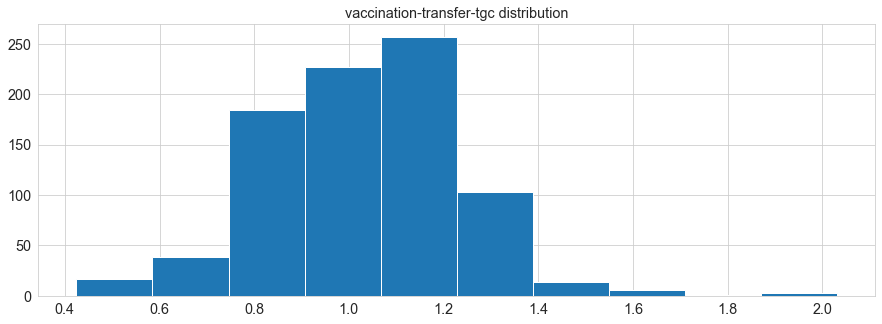

<Figure size 1080x360 with 0 Axes>

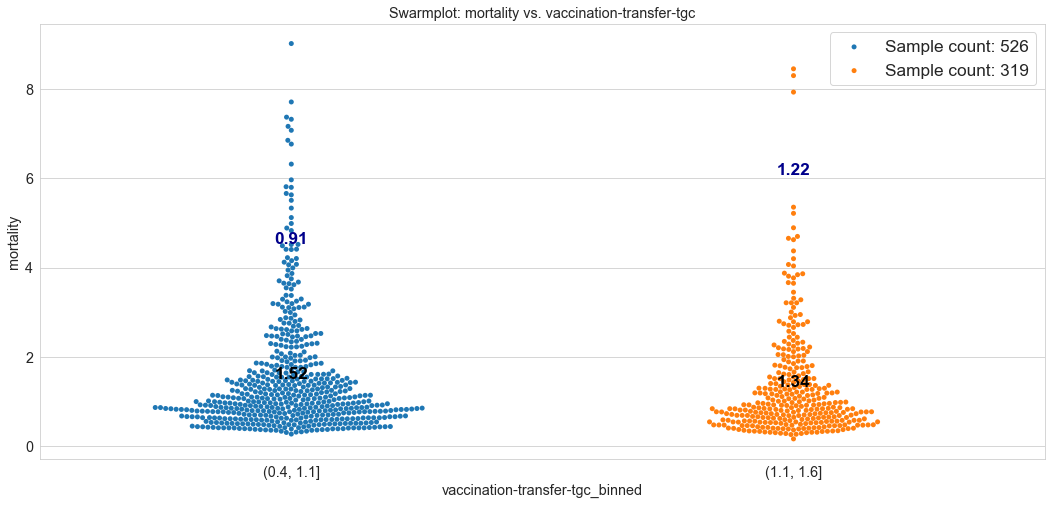

<Figure size 1080x360 with 0 Axes>

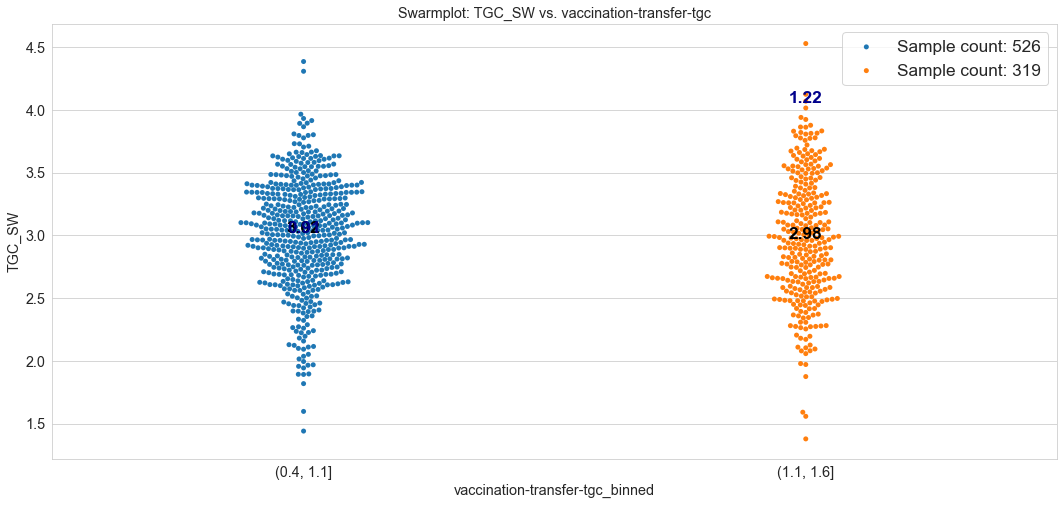

In [149]:
factor = 'vaccination-transfer-tgc'
feed_factors[factor].hist()
plt.title(f'{factor} distribution')
plt.show()

plot_swarm(feed_factors,
           factor=factor,
           target='mortality',
           bins=(0.4, 1.1, 1.6),
           y_scale=0.2)

plot_swarm(feed_factors,
           factor=factor,
           target='TGC_SW',
           bins=(0.4, 1.1, 1.6),
           y_scale=0.3)

### FCR

<AxesSubplot:>

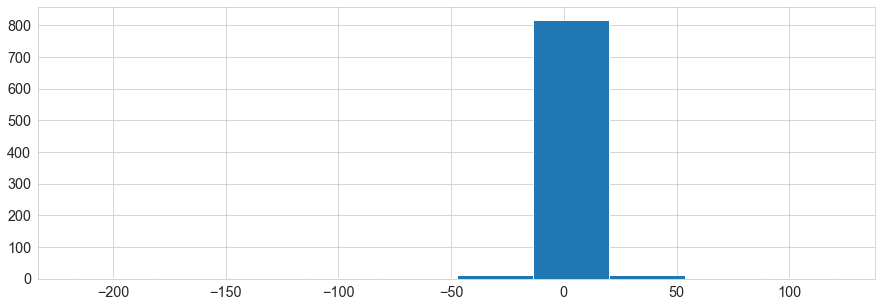

In [200]:
factor = 'vaccination-transfer-fcr'
feed_factors[factor].hist()

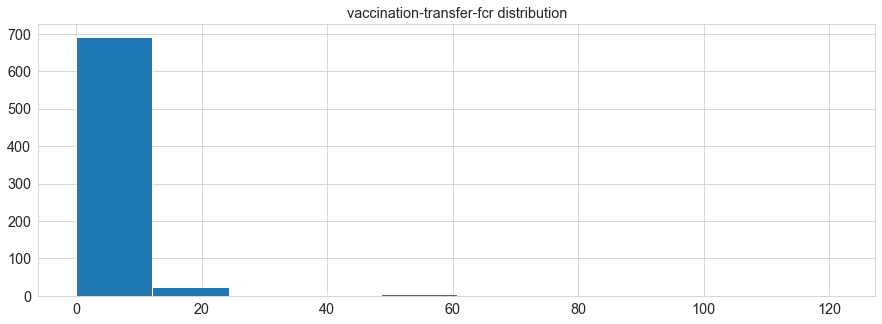

<Figure size 1080x360 with 0 Axes>

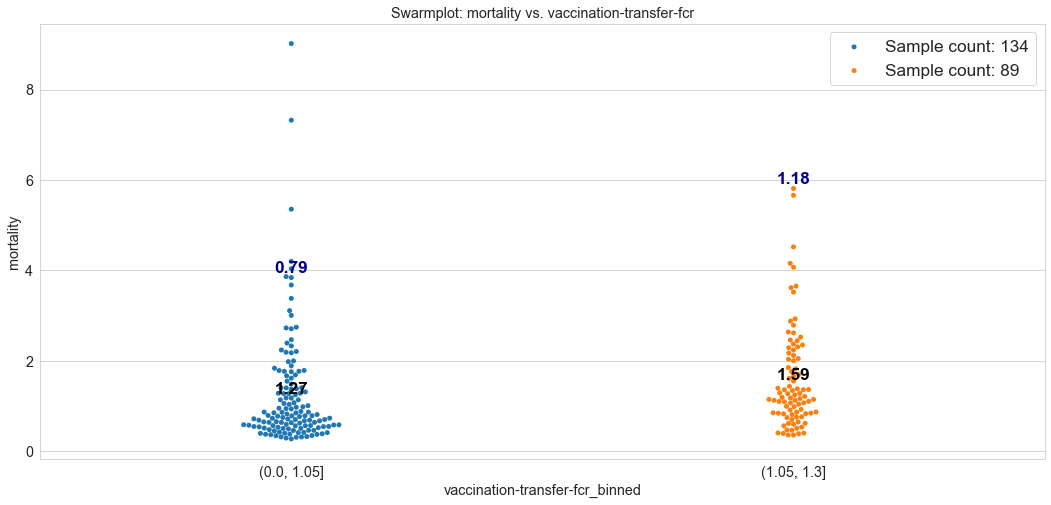

<Figure size 1080x360 with 0 Axes>

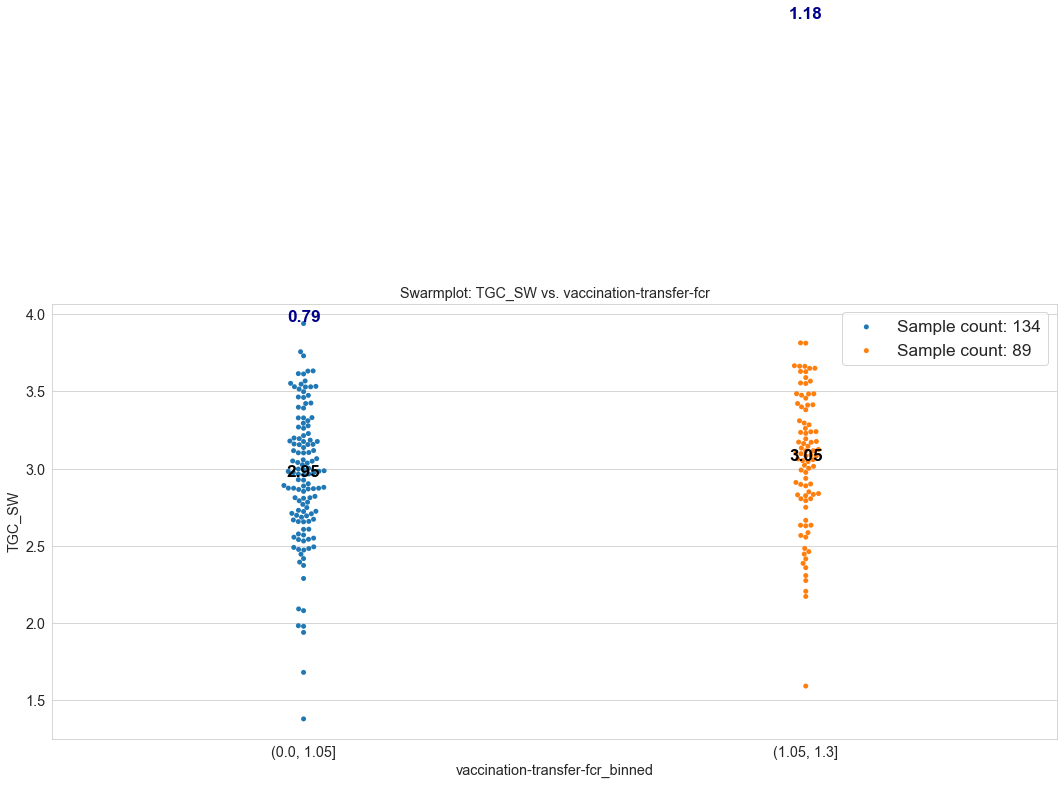

In [177]:
factor = 'vaccination-transfer-fcr'
feed_factors[feed_factors[factor] > 0][factor].hist()
plt.title(f'{factor} distribution')
plt.show()

plot_swarm(feed_factors,
           factor=factor,
           target='mortality',
           bins=(0, 1.05, 1.3),
           y_scale=0.2)

plot_swarm(feed_factors,
           factor=factor,
           target='TGC_SW',
           bins=(0, 1.05, 1.3),
           y_scale=0.2)

In [99]:
feed_factors

,locus_id,fish_group_id,transfer_year,vaccination-transfer-fcr,vaccination-transfer-sfr,eight_last_weeks-fcr,eight_last_weeks-sfr,mortality,to_avg_weight
0,3046036,6165,2023,0.952670,0.906192,1.178383,0.987019,0.005902,130.0
1,3046043,498,2019,2.681791,2.109369,1.170111,0.886176,0.027014,126.0
2,3046052,847,2019,2.066126,1.980706,1.087107,0.947632,0.018027,155.0
3,3046064,6217,2023,1.052268,0.911590,1.038279,0.937753,0.008624,184.0
4,3046100,690,2018,3.927823,3.443661,1.322116,1.196000,0.009344,118.0
...,...,...,...,...,...,...,...,...,...
572,7205278,6914,2023,1.054853,1.063062,1.066978,1.156991,0.009679,156.0
573,7205279,6909,2023,1.089812,0.815714,1.123122,0.841716,0.007952,128.0
574,7205280,6909,2023,1.423953,1.359300,0.908613,0.956693,0.015256,173.0
575,7205281,6909,2023,1.079476,0.787665,1.111967,0.811547,0.007381,126.0


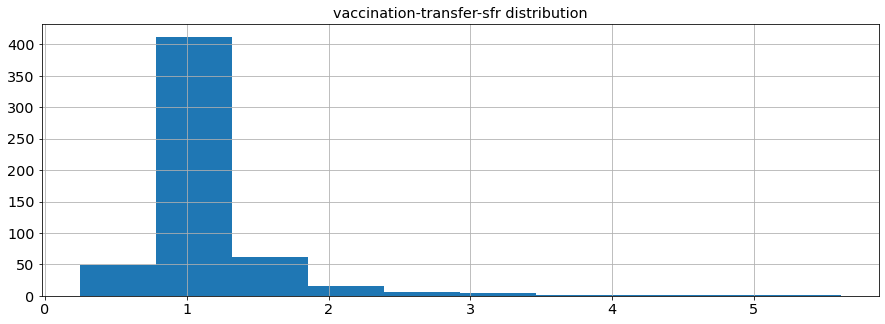

ValueError: Could not interpret value `TGC_SW` for parameter `y`

<Figure size 1080x360 with 0 Axes>

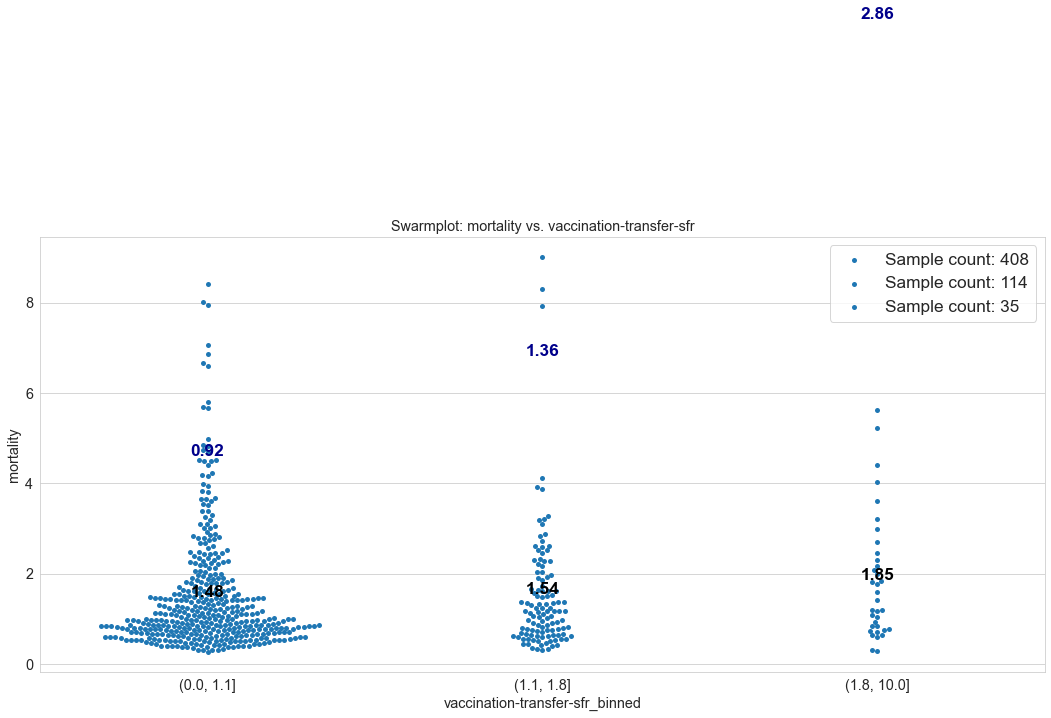

<Figure size 1080x360 with 0 Axes>

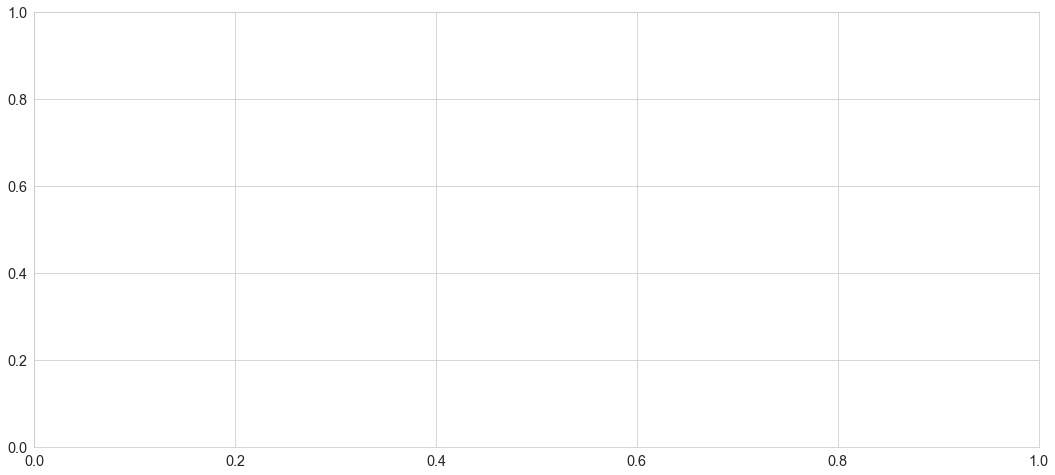

In [100]:
factor = 'vaccination-transfer-sfr'
feed_factors[feed_factors[factor].between(0, 10)][factor].hist()
plt.title(f'{factor} distribution')
plt.show()

plot_swarm(feed_factors,
           factor=factor,
           target='mortality',
           bins=(0, 1.1, 1.8, 10),
           y_scale=0.2)

plot_swarm(feed_factors,
           factor=factor,
           target='TGC_SW',
           bins=(0, 1.1, 1.8, 10),
           y_scale=0.2)

### Stop-feeding factors

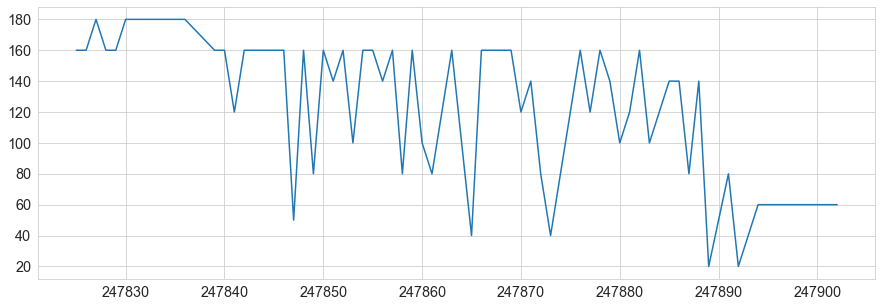

In [101]:
plt.plot(feed_data_extended[feed_data_extended['final_locus_population_id'] == 194650523]['amount'])

In [102]:
feed_data = feed_data_extended.copy()
feed_data['year'] = pd.to_datetime(feed_data['event_date']).dt.year
feed_data['month'] = pd.to_datetime(feed_data['event_date']).dt.month

average_amount = feed_data.groupby(['final_locus_population_id', 'year', 'month'])['amount'].mean().reset_index()
average_amount.rename(columns={'amount': 'month_average_amount'}, inplace=True)
feed_data = feed_data.merge(average_amount, how='inner', on=['final_locus_population_id', 'year', 'month'])

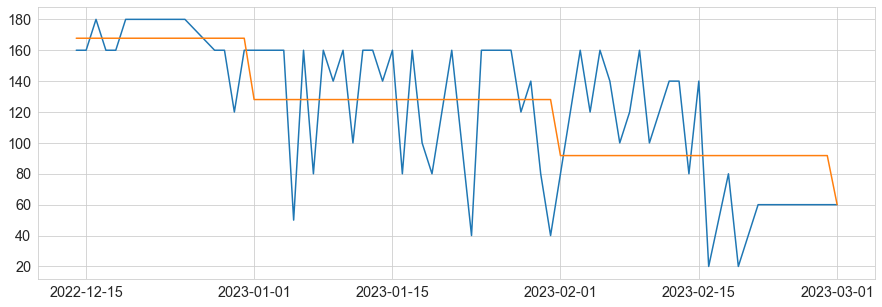

In [103]:
plt.plot(
    pd.to_datetime(feed_data[feed_data['final_locus_population_id'] == 194650523]['event_date']),
    feed_data[feed_data['final_locus_population_id'] == 194650523]['amount']
)

plt.plot(
    pd.to_datetime(feed_data[feed_data['final_locus_population_id'] == 194650523]['event_date']),
    feed_data[feed_data['final_locus_population_id'] == 194650523]['month_average_amount']
)
plt.show()

In [ ]:
coef_1 = 1 / 3

lower_mean_count = feed_data[feed_data['amount'] < feed_data['month_average_amount'] * coef_1]\
.groupby('final_locus_population_id').agg(count=("final_locus_population_id", "count"))
lower_mean_count.rename(columns={'count': 'lower_mean_days'}, inplace=True)

relative_lower_mean_count = lower_mean_count['lower_mean_days'] / \
feed_data.groupby('final_locus_population_id').agg(count=("final_locus_population_id", "count"))['count']
relative_lower_mean_count = pd.DataFrame(relative_lower_mean_count).rename(columns={0: 'relative_lower_mean_days'})

In [ ]:
feed_data = feed_data.merge(lower_mean_count, how='left', on=['final_locus_population_id'])
feed_data = feed_data.merge(relative_lower_mean_count, how='left', on=['final_locus_population_id'])
feed_data['amount_diff'] = feed_data.groupby('final_locus_population_id')['amount'].diff().fillna(0)

coef_2 = 1/2

drop_count = feed_data[abs(feed_data['amount_diff']) > coef_2 * feed_data['month_average_amount']][feed_data['amount_diff'] < 0]\
.groupby('final_locus_population_id').agg(count=("final_locus_population_id", "count")).rename(columns={'count': 'drop_count'})
feed_data = feed_data.merge(drop_count, how='left', on=['final_locus_population_id'])

In [ ]:
feed_data = feed_data.fillna(0)

feed_data = feed_data.groupby('final_locus_population_id')\
[['drop_count', 'lower_mean_days', 'relative_lower_mean_days']].mean()

In [ ]:
feed_data['relative_lower_mean_days'].hist()

<AxesSubplot:>

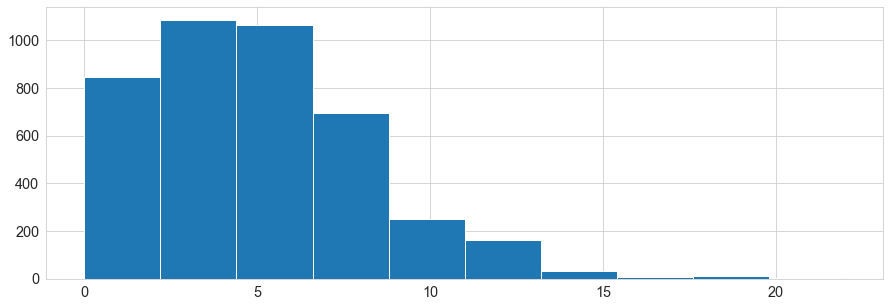

In [108]:
feed_data['drop_count'].hist()

In [111]:
feed_factors_locus = feed_data.merge(
    mortality_final_locus[['from_locus_population_id', 'locus_id','fish_group_id', 'transfer_year', 'from_count_stocking']],
    left_on=['final_locus_population_id',],
    right_on=['from_locus_population_id',],
    how='inner')

factors = ['drop_count', 'lower_mean_days', 'relative_lower_mean_days']

key_columns = ['locus_id','fish_group_id','transfer_year']

feed_factors_est = create_factors_df(feed_factors_locus,
                                     factors,
                                     key_columns, 
                                     weight_column='from_count_stocking',
                                     weighted_func=weighted_avg)

feed_factors_est = feed_factors_est.merge(
    pd.DataFrame(mortality_final_locus.groupby(key_columns)['total_mortality_perc_90'].mean()),
    on=key_columns,
    how='inner'
)

#feed_factors_est = feed_factors_est.merge(
#    pd.DataFrame(tgc.groupby(key_columns)['TGC_SW'].mean()),
#    on=key_columns,
#    how='inner'
#)

feed_factors_est.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)

feed_factors_est.to_csv('../data/factors_feed_est.csv', index=False)

Weighting factors


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


In [112]:
feed_factors_est

,locus_id,fish_group_id,transfer_year,drop_count,lower_mean_days,relative_lower_mean_days,mortality
0,3046036,1052,2019,3.475054,1.425161,0.026890,0.003943
1,3046036,3918,2020,5.000000,3.000000,0.062500,0.007676
2,3046036,6165,2023,5.291908,0.145954,0.001972,0.005902
3,3046043,498,2019,3.000000,3.000000,0.031579,0.027014
4,3046052,847,2019,11.106481,3.106481,0.026486,0.018027
...,...,...,...,...,...,...,...
949,7205278,6914,2023,5.892758,2.678275,0.041848,0.009679
950,7205279,6909,2023,8.000000,1.000000,0.014085,0.007952
951,7205280,6909,2023,8.984055,3.989370,0.031412,0.015256
952,7205281,6909,2023,5.667053,1.583237,0.021218,0.007381


## Factor Analysis: estimated factors

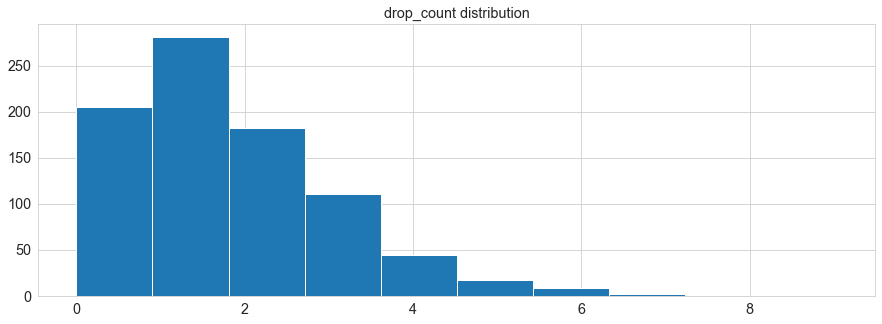

<Figure size 1080x360 with 0 Axes>

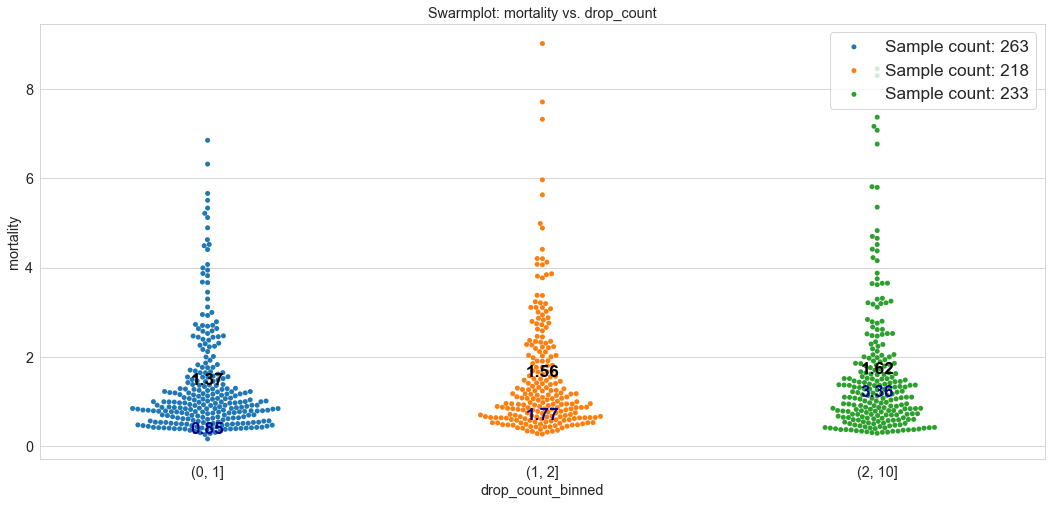

<Figure size 1080x360 with 0 Axes>

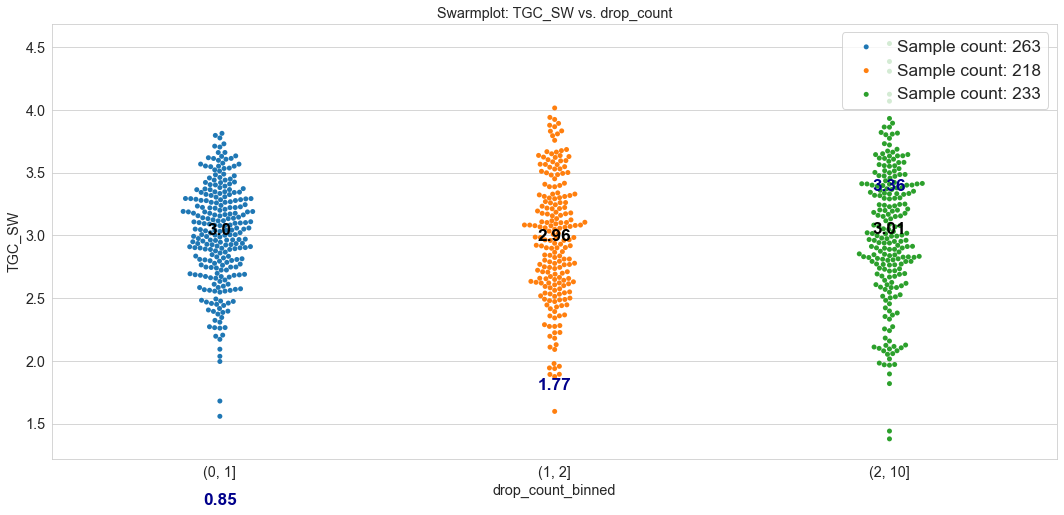

In [190]:
factor = 'drop_count'
feed_factors_est[factor].hist()
plt.title(f'{factor} distribution')
plt.show()

plot_swarm(feed_factors_est,
           factor=factor,
           target='mortality',
           bins=(0, 1, 2, 10),
           y_scale=3)

plot_swarm(feed_factors_est,
           factor=factor,
           target='TGC_SW',
           bins=(0, 1, 2, 10),
           y_scale=1)

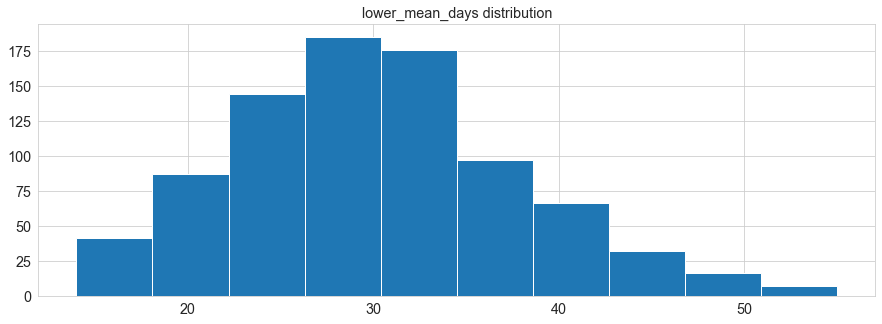

<Figure size 1080x360 with 0 Axes>

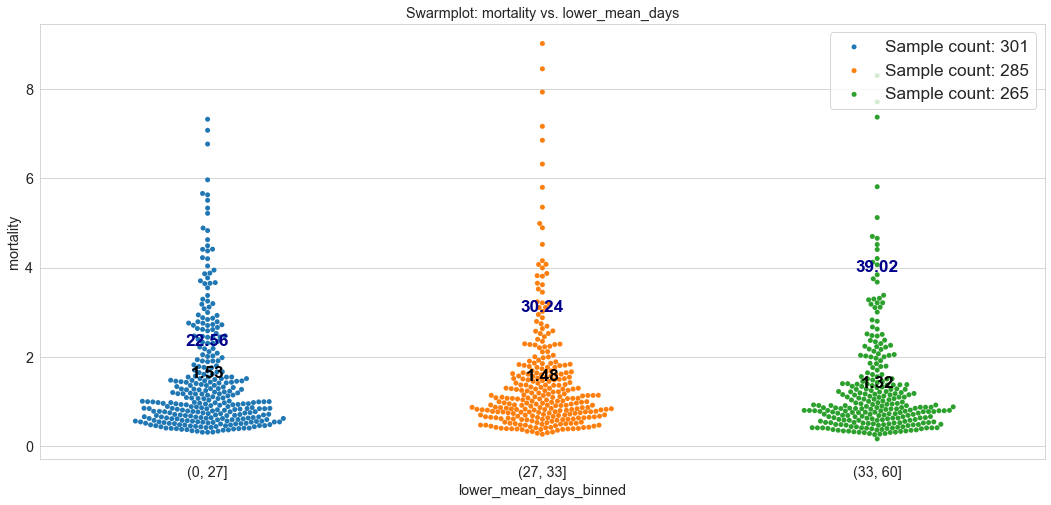

<Figure size 1080x360 with 0 Axes>

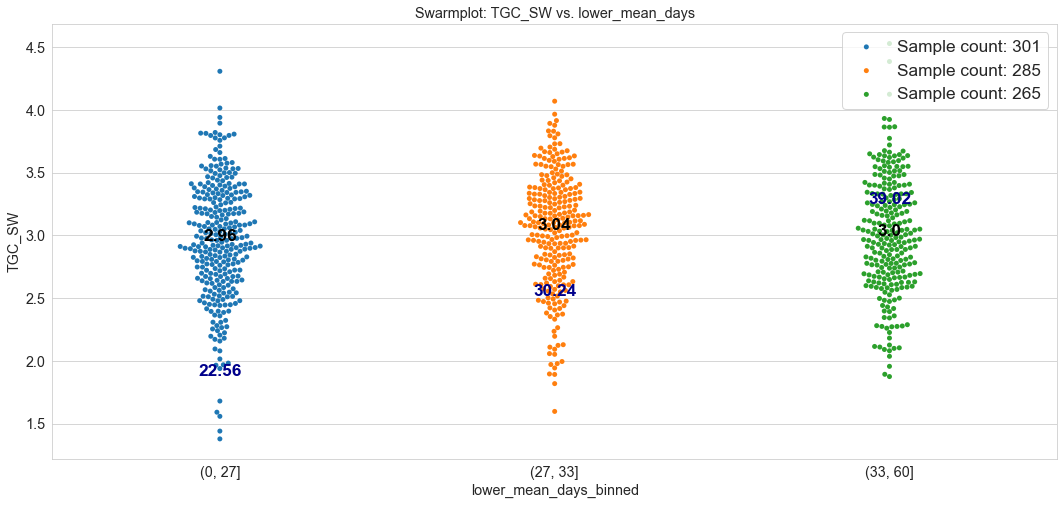

In [200]:
factor = 'lower_mean_days'
feed_factors_est[factor].hist()
plt.title(f'{factor} distribution')
plt.show()

plot_swarm(feed_factors_est,
           factor=factor,
           target='mortality',
           bins=(0, 27, 33, 60),
           y_scale=10)

plot_swarm(feed_factors_est,
           factor=factor,
           target='TGC_SW',
           bins=(0, 27, 33, 60),
           y_scale=12)

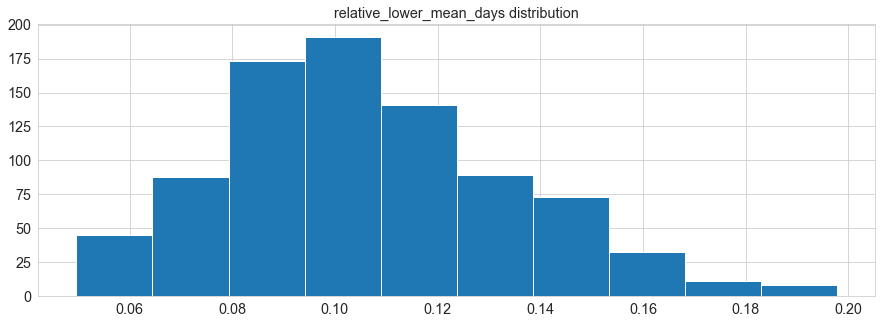

<Figure size 1080x360 with 0 Axes>

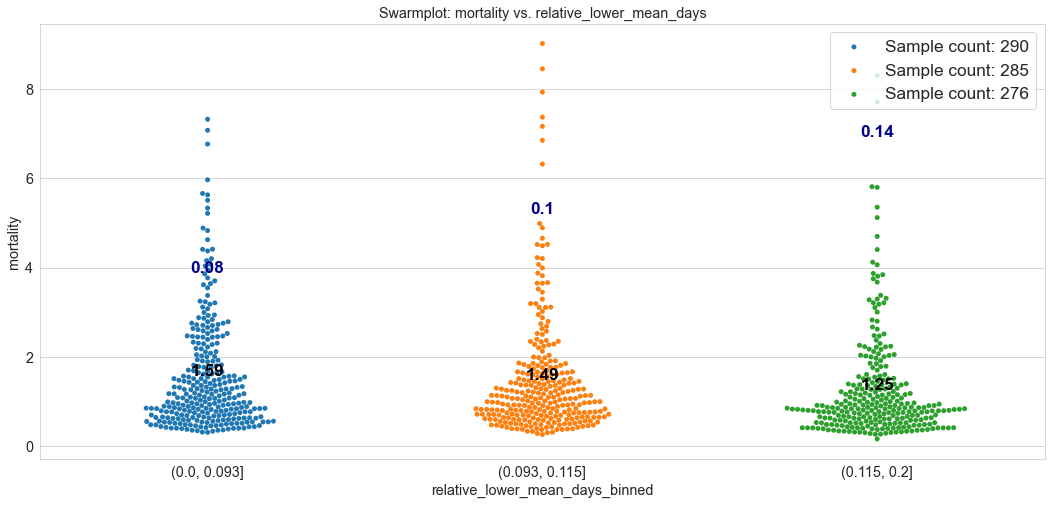

<Figure size 1080x360 with 0 Axes>

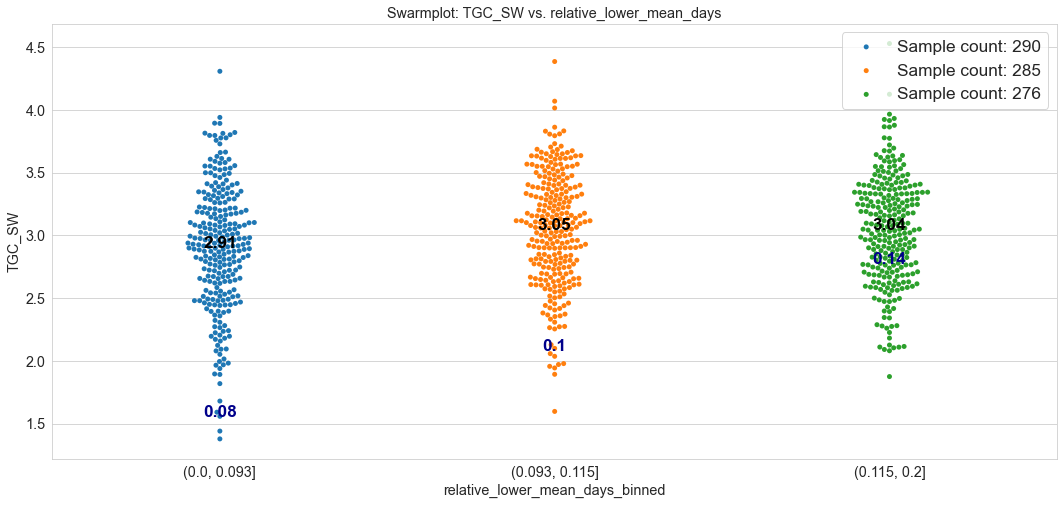

In [209]:
factor = 'relative_lower_mean_days'
feed_factors_est[factor].hist()
plt.title(f'{factor} distribution')
plt.show()

plot_swarm(feed_factors_est,
           factor=factor,
           target='mortality',
           bins=(0, 0.093, 0.115, 0.2),
           y_scale=0.02)

plot_swarm(feed_factors_est,
           factor=factor,
           target='TGC_SW',
           bins=(0, 0.093, 0.115, 0.2),
           y_scale=0.05)

### Combime factors

In [113]:
feed_factors

,locus_id,fish_group_id,transfer_year,vaccination-transfer-fcr,vaccination-transfer-sfr,eight_last_weeks-fcr,eight_last_weeks-sfr,mortality,to_avg_weight
0,3046036,6165,2023,0.952670,0.906192,1.178383,0.987019,0.005902,130.0
1,3046043,498,2019,2.681791,2.109369,1.170111,0.886176,0.027014,126.0
2,3046052,847,2019,2.066126,1.980706,1.087107,0.947632,0.018027,155.0
3,3046064,6217,2023,1.052268,0.911590,1.038279,0.937753,0.008624,184.0
4,3046100,690,2018,3.927823,3.443661,1.322116,1.196000,0.009344,118.0
...,...,...,...,...,...,...,...,...,...
572,7205278,6914,2023,1.054853,1.063062,1.066978,1.156991,0.009679,156.0
573,7205279,6909,2023,1.089812,0.815714,1.123122,0.841716,0.007952,128.0
574,7205280,6909,2023,1.423953,1.359300,0.908613,0.956693,0.015256,173.0
575,7205281,6909,2023,1.079476,0.787665,1.111967,0.811547,0.007381,126.0


In [225]:
feed_factors_est

,locus_id,fish_group_id,transfer_year,drop_count,lower_mean_days,relative_lower_mean_days,mortality,TGC_SW
0,3046036,1052,2019,6.950108,9.325376,0.039018,0.003943,3.291903
1,3046036,3918,2020,12.000000,12.000000,0.046875,0.007676,2.771383
2,3046036,6165,2023,8.437862,8.291908,0.028791,0.005902,2.530637
3,3046043,498,2019,10.000000,6.000000,0.021583,0.027014,3.419715
4,3046052,847,2019,15.702160,7.212963,0.026653,0.018027,3.020111
...,...,...,...,...,...,...,...,...
846,7183889,6071,2022,11.000000,18.000000,0.058252,0.012813,3.623094
847,7183890,6072,2022,8.086558,18.377122,0.062507,0.014813,3.101141
848,7183891,6072,2022,15.000000,13.000000,0.044218,0.014654,2.995160
849,7183892,6069,2022,12.459600,15.009267,0.051783,0.022576,3.020299


In [115]:
feed_factors_combined = pd.merge(feed_factors, feed_factors_est,
                                 on=['locus_id', 'fish_group_id', 'transfer_year', 'mortality'],
                                 how='inner')
feed_factors_combined = feed_factors_combined[[c for c in feed_factors_combined if c not in ['mortality',]] + ['mortality',]]

In [116]:
feed_factors_combined

,locus_id,fish_group_id,transfer_year,vaccination-transfer-fcr,vaccination-transfer-sfr,eight_last_weeks-fcr,eight_last_weeks-sfr,to_avg_weight,drop_count,lower_mean_days,relative_lower_mean_days,mortality
0,3046036,6165,2023,0.952670,0.906192,1.178383,0.987019,130.0,5.291908,0.145954,0.001972,0.005902
1,3046043,498,2019,2.681791,2.109369,1.170111,0.886176,126.0,3.000000,3.000000,0.031579,0.027014
2,3046052,847,2019,2.066126,1.980706,1.087107,0.947632,155.0,11.106481,3.106481,0.026486,0.018027
3,3046064,6217,2023,1.052268,0.911590,1.038279,0.937753,184.0,2.802380,2.197620,0.027388,0.008624
4,3046100,690,2018,3.927823,3.443661,1.322116,1.196000,118.0,11.707209,3.414418,0.037045,0.009344
...,...,...,...,...,...,...,...,...,...,...,...,...
572,7205278,6914,2023,1.054853,1.063062,1.066978,1.156991,156.0,5.892758,2.678275,0.041848,0.009679
573,7205279,6909,2023,1.089812,0.815714,1.123122,0.841716,128.0,8.000000,1.000000,0.014085,0.007952
574,7205280,6909,2023,1.423953,1.359300,0.908613,0.956693,173.0,8.984055,3.989370,0.031412,0.015256
575,7205281,6909,2023,1.079476,0.787665,1.111967,0.811547,126.0,5.667053,1.583237,0.021218,0.007381


In [117]:
feed_factors_combined.to_csv('../data/feed_factors.csv', index=False)

### Updated File: FCR + SFR


In [121]:
feed_data_extended_upd = pd.read_csv('./data/feed_data_extended_unsmoothed.csv')

FileNotFoundError: [Errno 2] No such file or directory: './data/feed_data_extended_unsmoothed.csv'

In [119]:
feed_data_extended_upd

NameError: name 'feed_data_extended_upd' is not defined

In [120]:
periods = ['first_feeding-transfer', 'first_feeding-vaccination', 'vaccination-transfer']

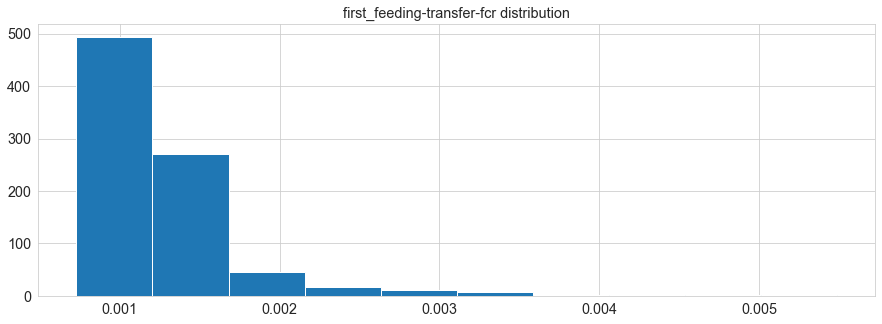

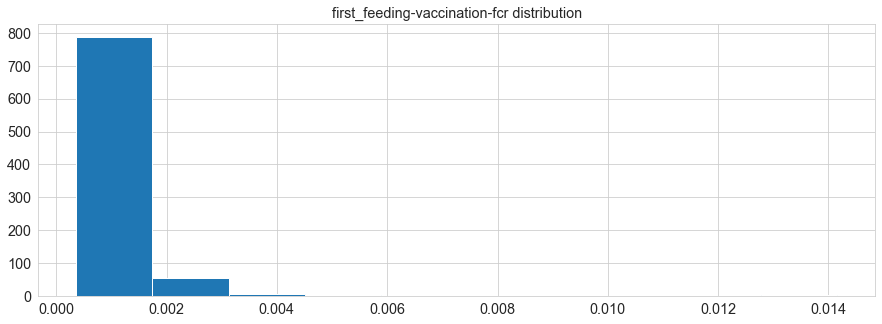

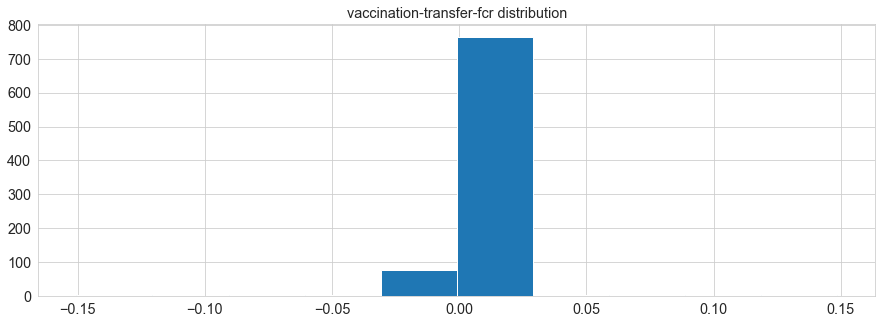

In [106]:
factor = 'fcr'

for period in periods:
    plt.figure()
    feed_factors[f'{period}-{factor}'].hist()
    plt.title(f'{period}-{factor} distribution')
    plt.show()

<Figure size 1080x360 with 0 Axes>

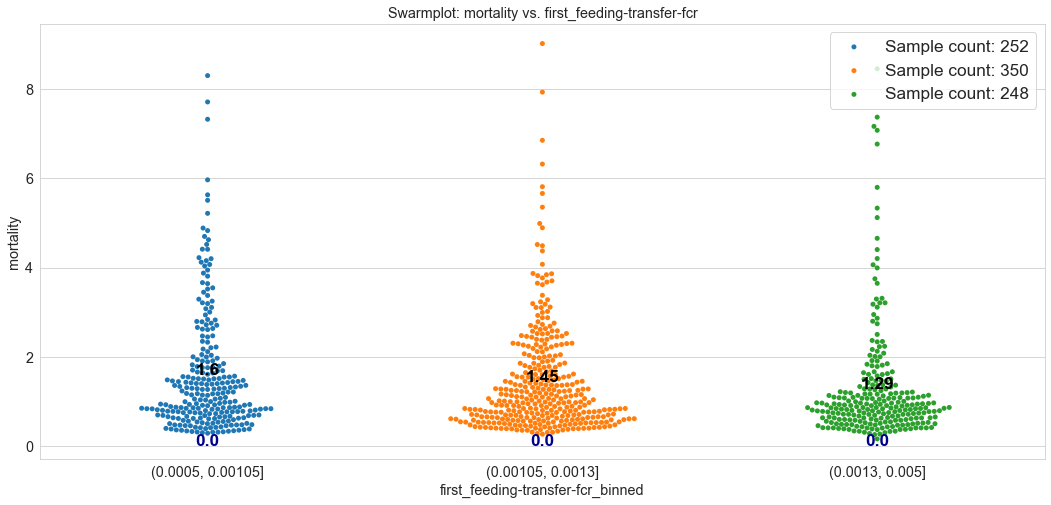

<Figure size 1080x360 with 0 Axes>

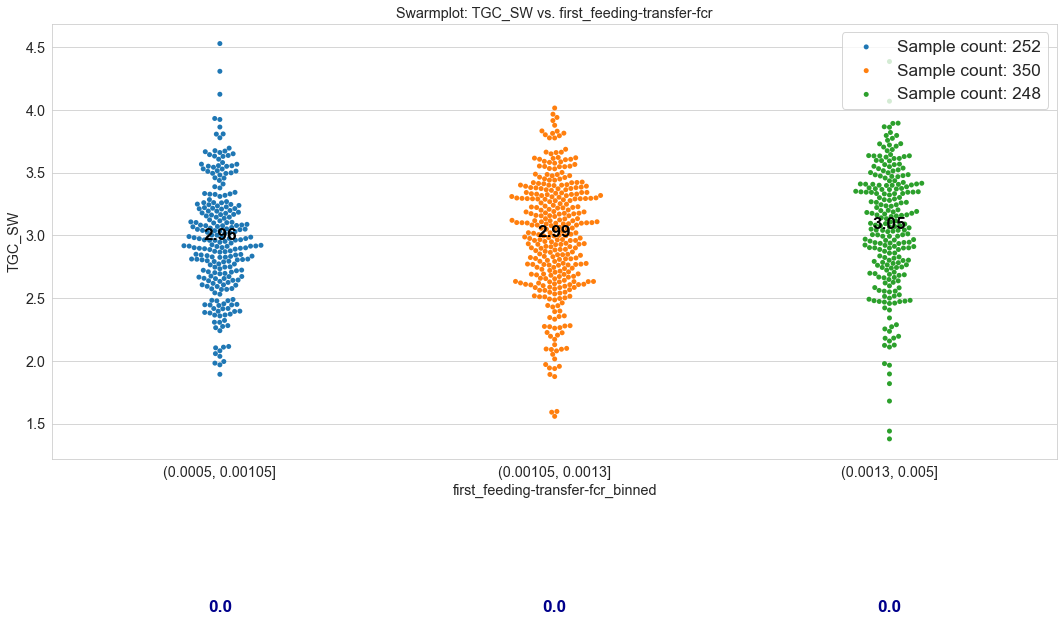

<Figure size 1080x360 with 0 Axes>

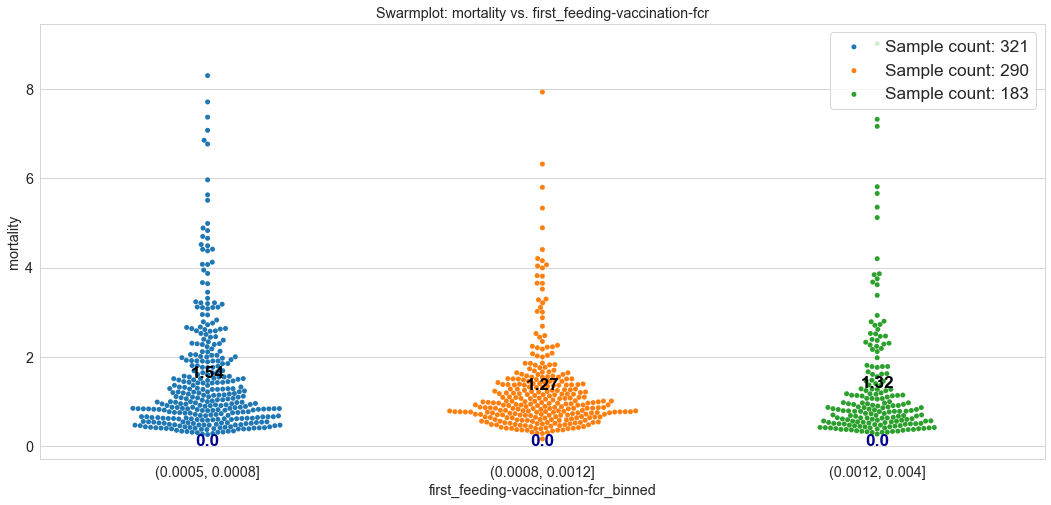

<Figure size 1080x360 with 0 Axes>

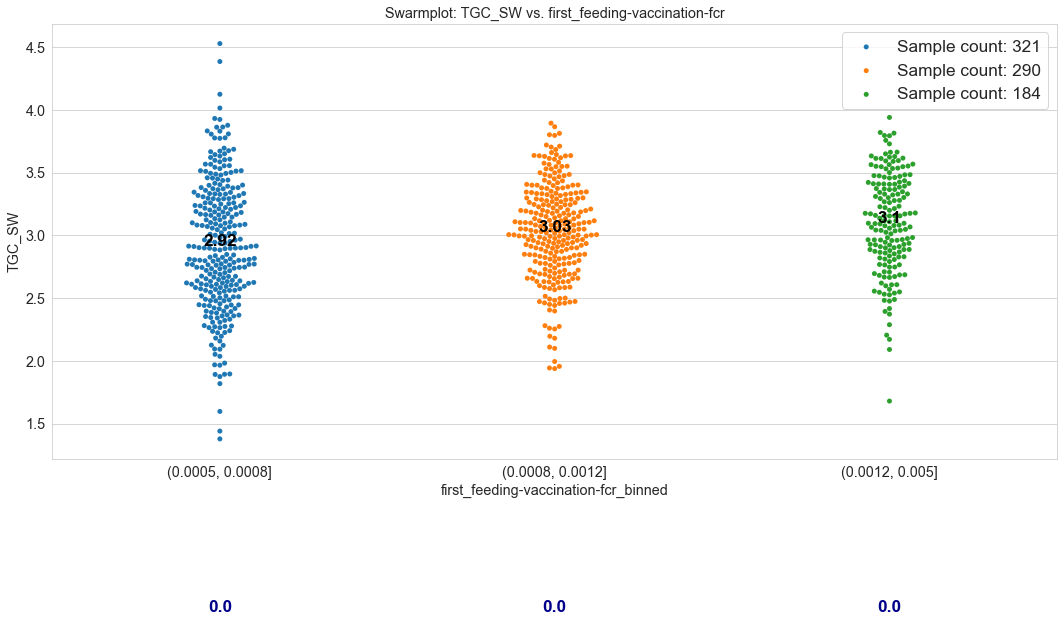

<Figure size 1080x360 with 0 Axes>

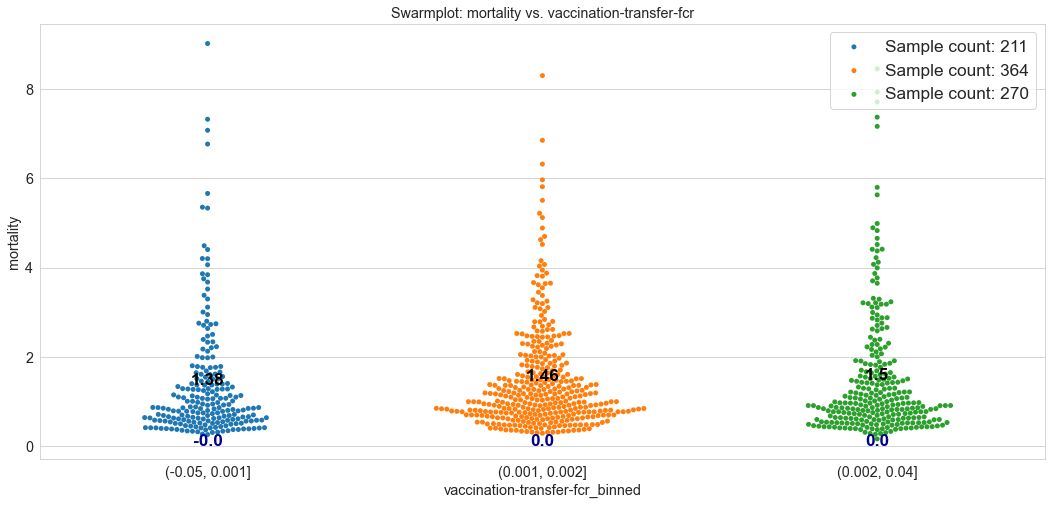

<Figure size 1080x360 with 0 Axes>

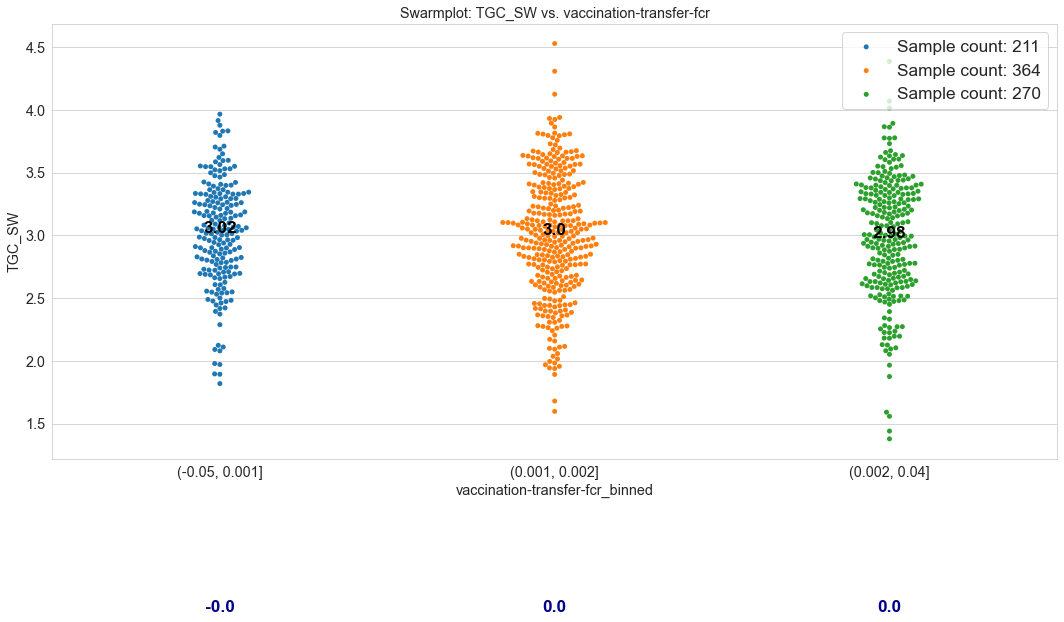

In [112]:
plot_swarm(feed_factors,
           factor=f'{periods[0]}-{factor}',
           target='mortality',
           bins=(0.001/2, 0.00105, 0.0013, 0.005),
           y_scale=10)

plot_swarm(feed_factors,
           factor=f'{periods[0]}-{factor}',
           target='TGC_SW',
           bins=(0.001/2, 0.00105, 0.0013, 0.005),
           y_scale=10)

plot_swarm(feed_factors,
           factor=f'{periods[1]}-{factor}',
           target='mortality',
           bins=(0.001/2, 0.0008, 0.0012, 0.004),
           y_scale=10)

plot_swarm(feed_factors,
           factor=f'{periods[1]}-{factor}',
           target='TGC_SW',
           bins=(0.001/2, 0.0008, 0.0012, 0.005),
           y_scale=10)

plot_swarm(feed_factors,
           factor=f'{periods[2]}-{factor}',
           target='mortality',
           bins=(-0.05, 0.01/10, 0.01/5, 0.04),
           y_scale=10)

plot_swarm(feed_factors,
           factor=f'{periods[2]}-{factor}',
           target='TGC_SW',
           bins=(-0.05, 0.01/10, 0.01/5, 0.04),
           y_scale=10)

### Finding 2: SFR

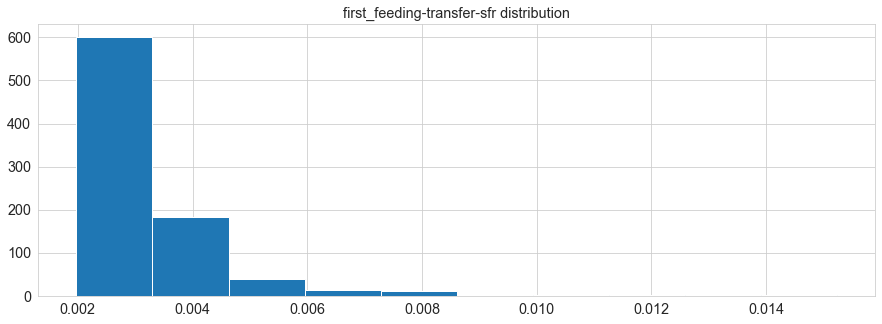

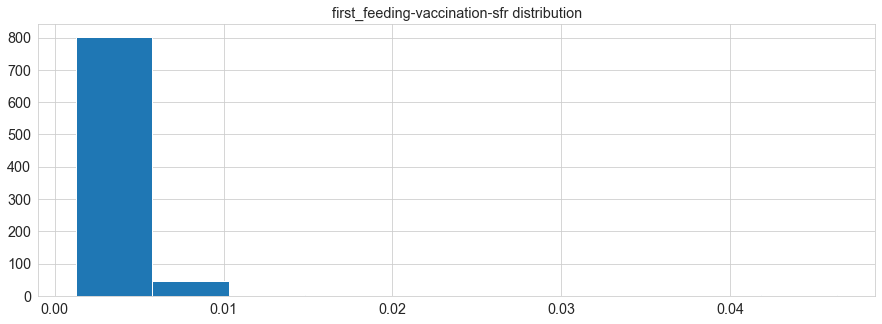

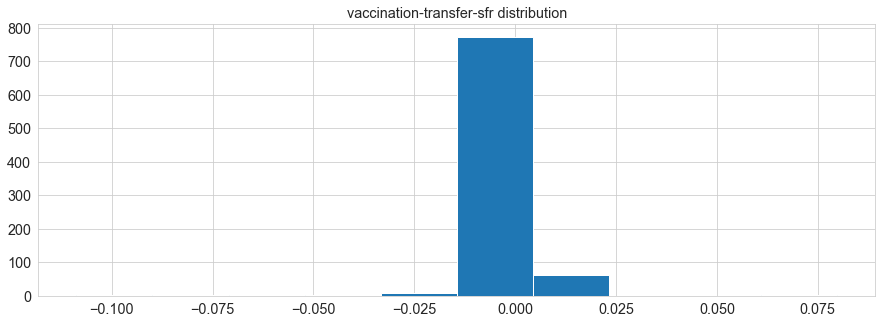

In [113]:
factor = 'sfr'
for period in periods:
    plt.figure()
    feed_factors[f'{period}-{factor}'].hist()
    plt.title(f'{period}-{factor} distribution')
    plt.show()

<Figure size 1080x360 with 0 Axes>

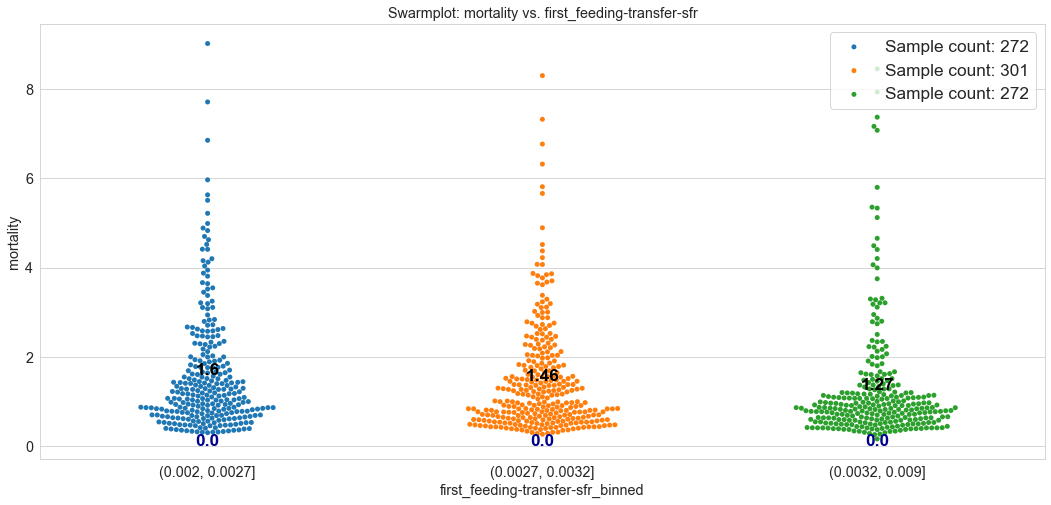

<Figure size 1080x360 with 0 Axes>

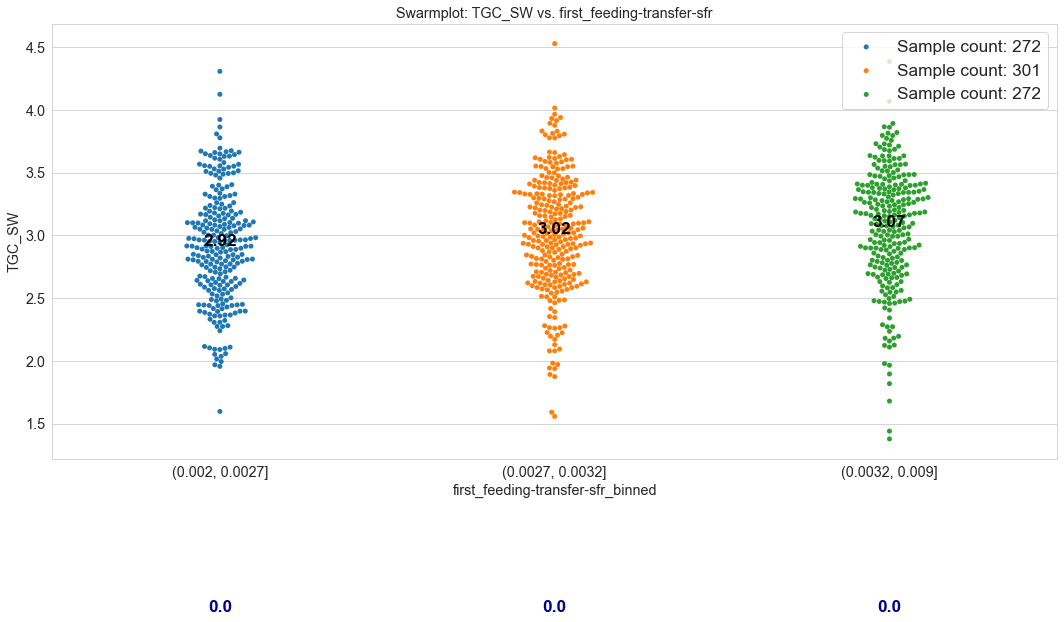

<Figure size 1080x360 with 0 Axes>

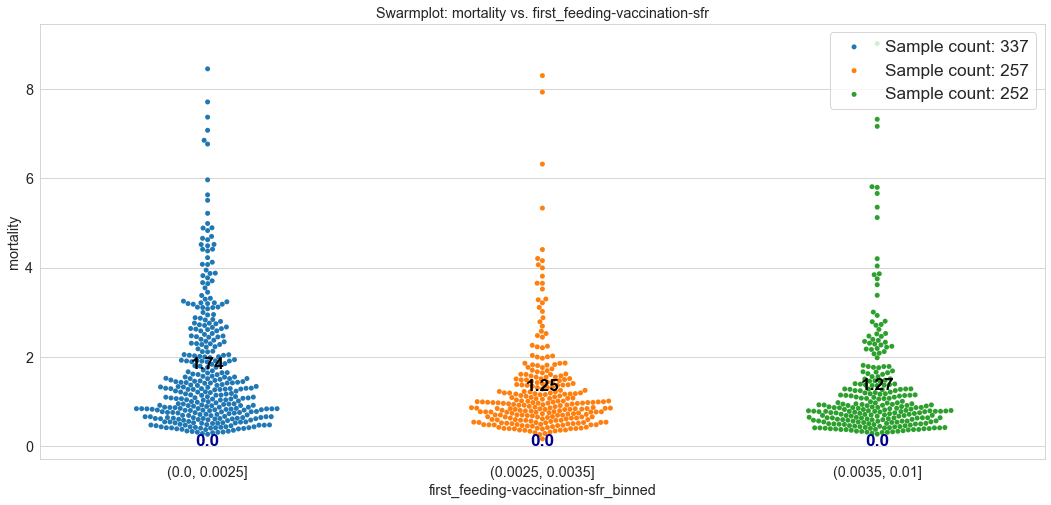

<Figure size 1080x360 with 0 Axes>

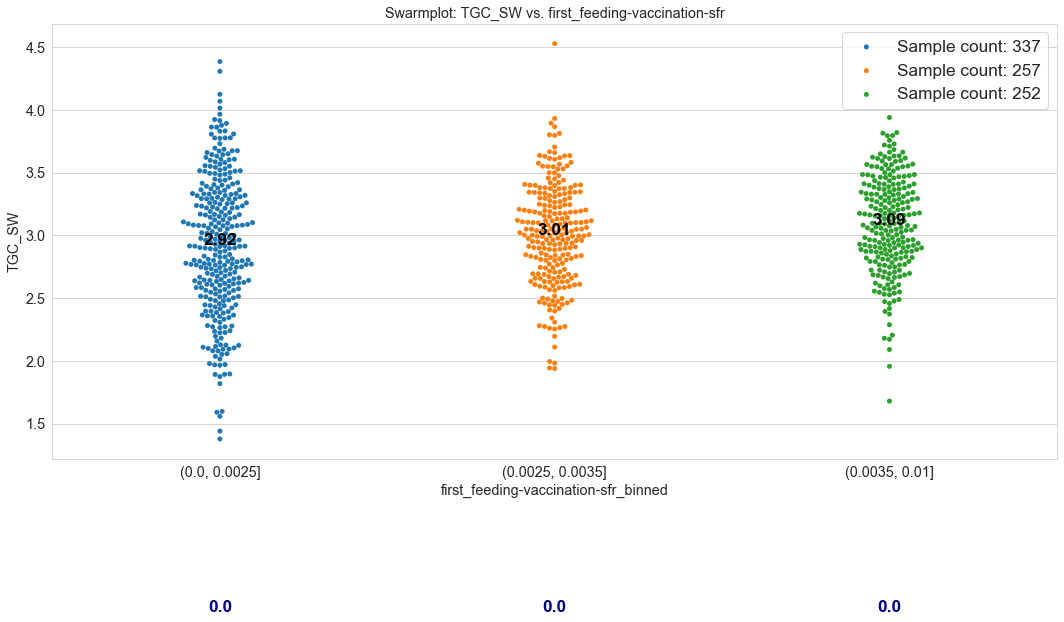

<Figure size 1080x360 with 0 Axes>

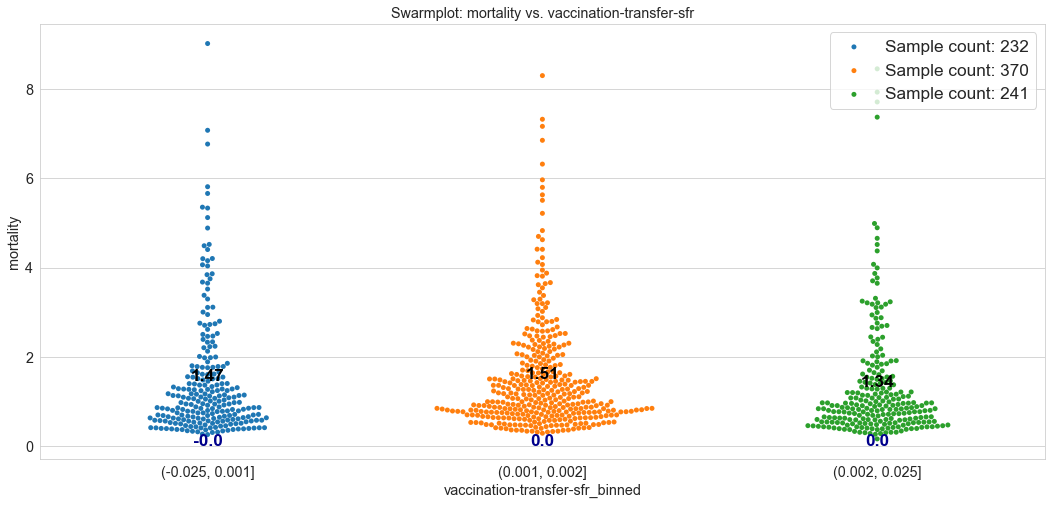

<Figure size 1080x360 with 0 Axes>

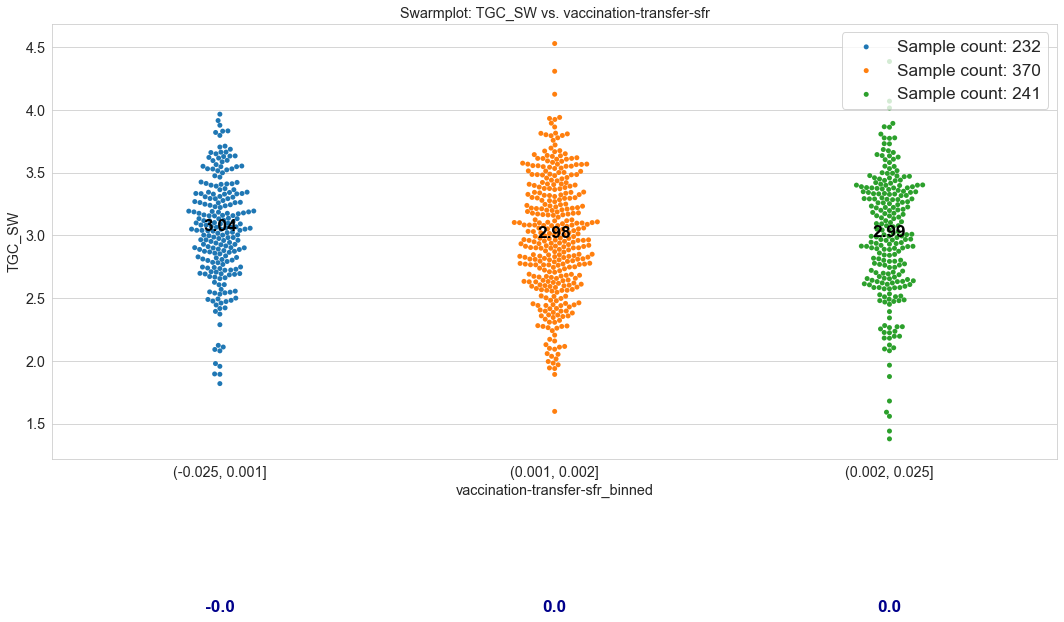

In [114]:
plot_swarm(feed_factors,
           factor=f'{periods[0]}-{factor}',
           target='mortality',
           bins=(0.002, 0.0027, 0.0032, 0.009),
           y_scale=10)

plot_swarm(feed_factors,
           factor=f'{periods[0]}-{factor}',
           target='TGC_SW',
           bins=(0.002, 0.0027, 0.0032, 0.009),
           y_scale=10)

plot_swarm(feed_factors,
           factor=f'{periods[1]}-{factor}',
           target='mortality',
           bins=(0, 0.0025, 0.0035, 0.01),
           y_scale=10)

plot_swarm(feed_factors,
           factor=f'{periods[1]}-{factor}',
           target='TGC_SW',
           bins=(0, 0.0025, 0.0035, 0.01),
           y_scale=10)

plot_swarm(feed_factors,
           factor=f'{periods[2]}-{factor}',
           target='mortality',
           bins=(-0.025, 0.01 / 10, 0.01 / 5, 0.025),
           y_scale=10)

plot_swarm(feed_factors,
           factor=f'{periods[2]}-{factor}',
           target='TGC_SW',
           bins=(-0.025, 0.01 / 10, 0.01 / 5, 0.025),
           y_scale=10)

### Finding 3: SGR

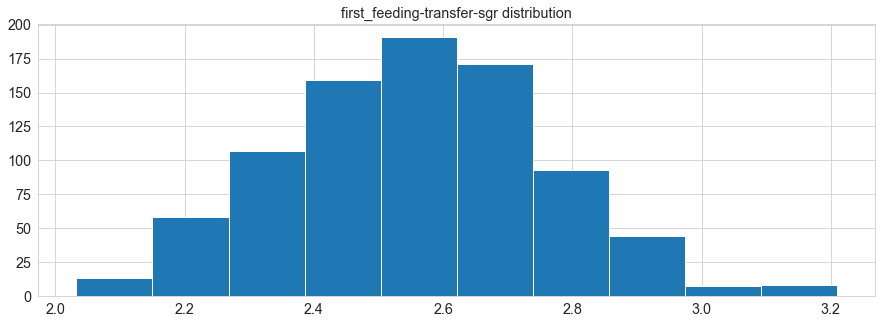

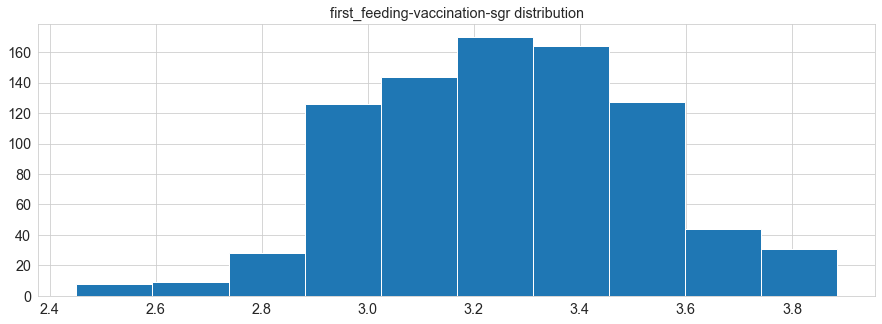

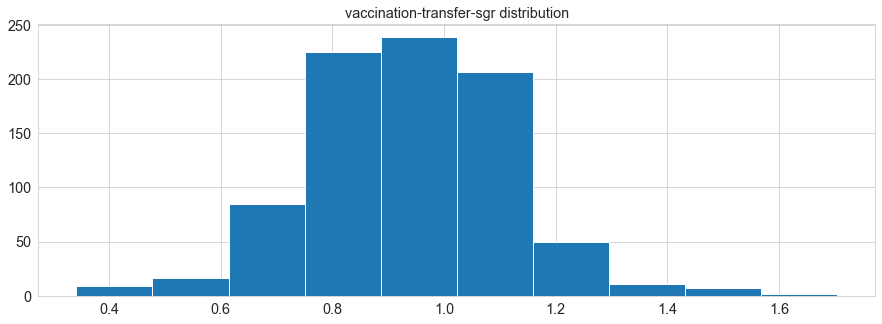

In [115]:
factor = 'sgr'
for period in periods:
    plt.figure()
    feed_factors[f'{period}-{factor}'].hist()
    plt.title(f'{period}-{factor} distribution')
    plt.show()

<Figure size 1080x360 with 0 Axes>

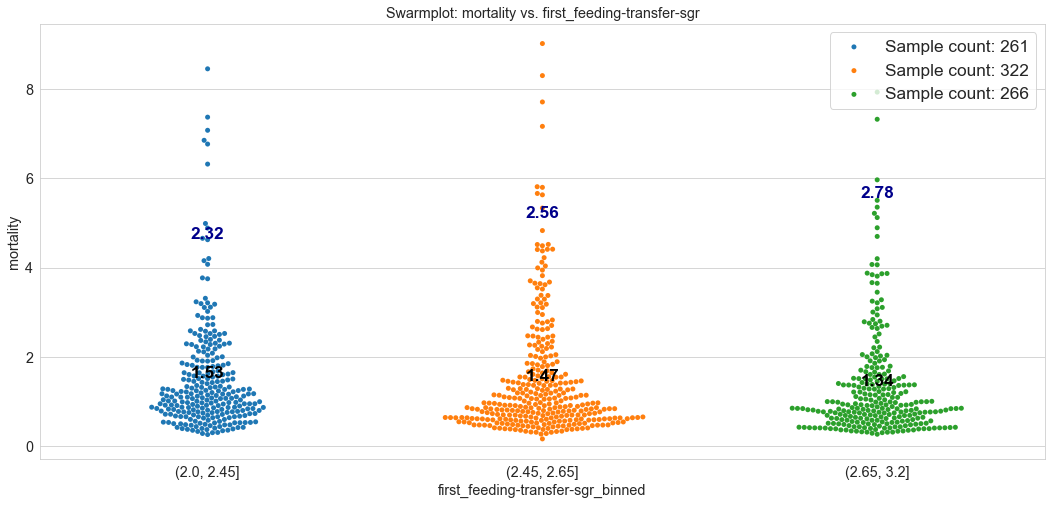

<Figure size 1080x360 with 0 Axes>

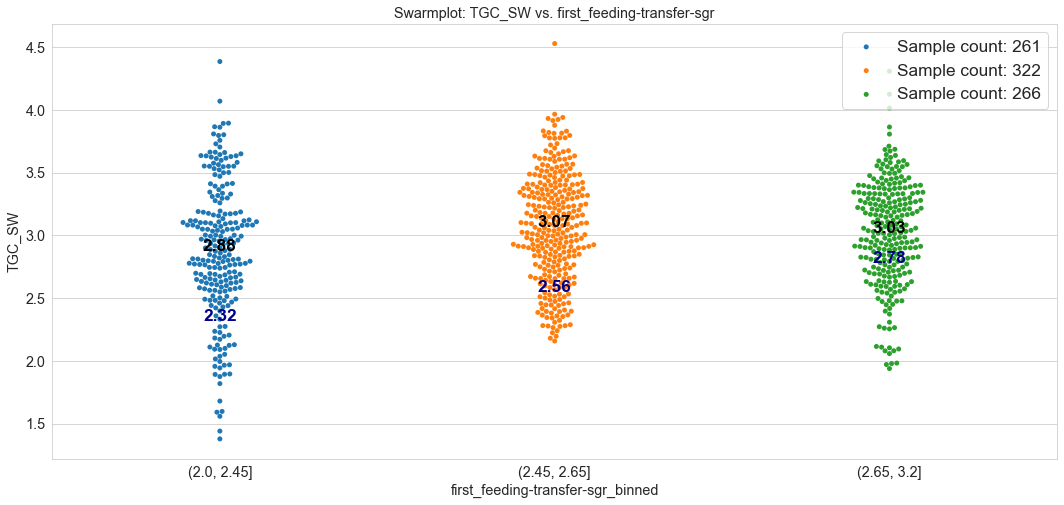

<Figure size 1080x360 with 0 Axes>

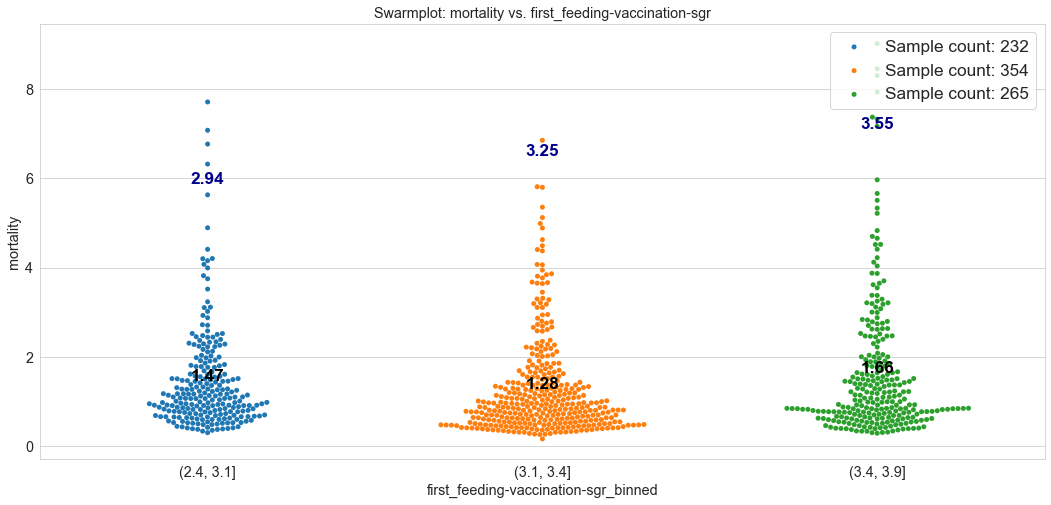

<Figure size 1080x360 with 0 Axes>

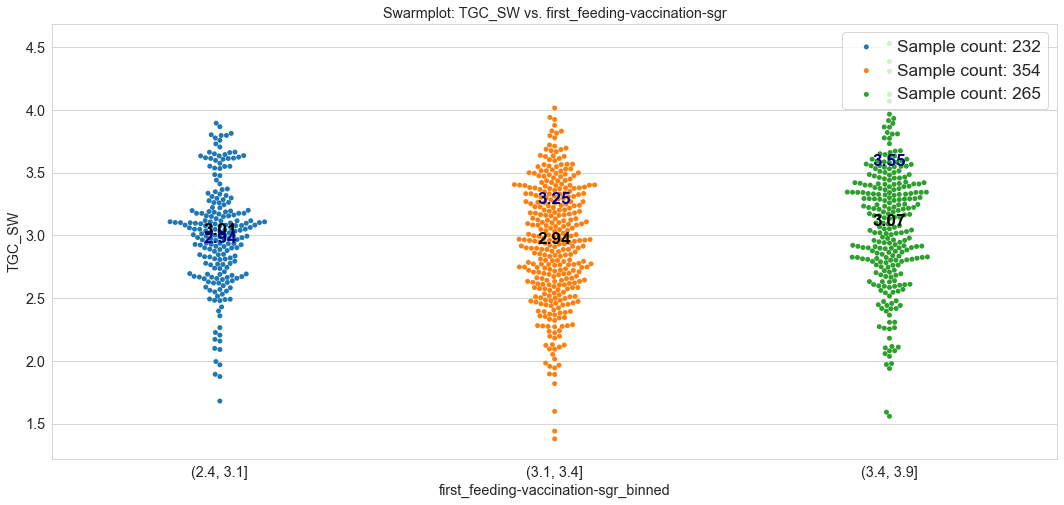

<Figure size 1080x360 with 0 Axes>

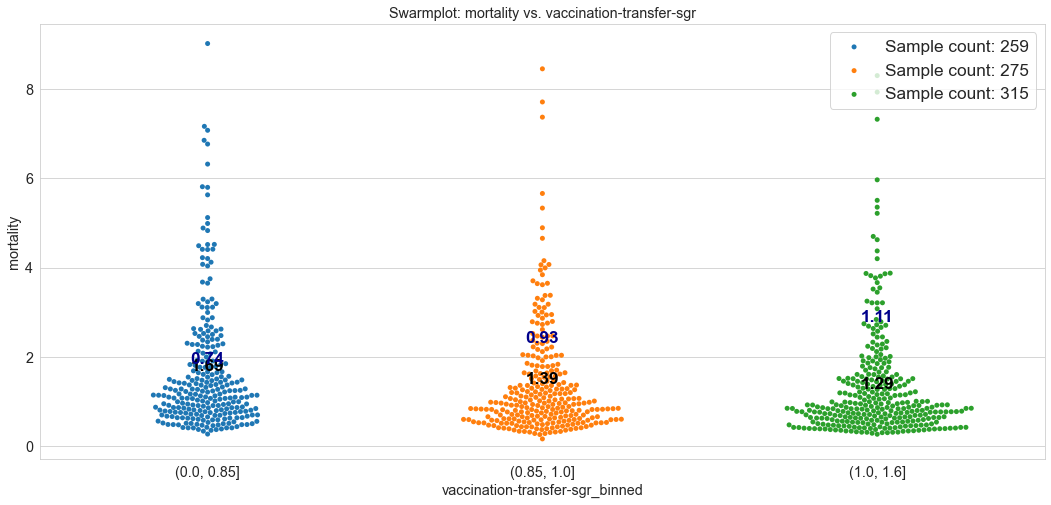

<Figure size 1080x360 with 0 Axes>

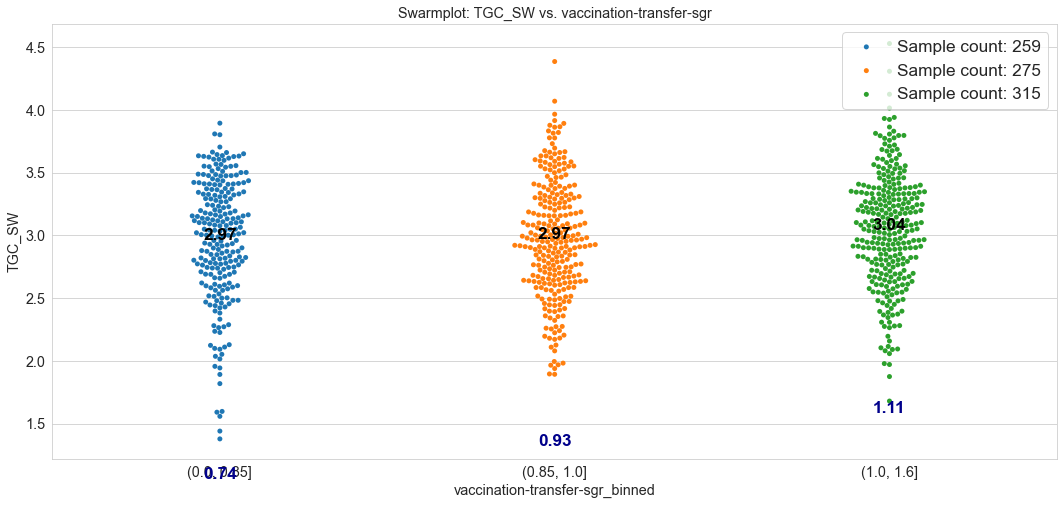

In [116]:
plot_swarm(feed_factors,
           factor=f'{periods[0]}-{factor}',
           target='mortality',
           bins=(2, 2.45, 2.65, 3.2),
           y_scale=0.5)

plot_swarm(feed_factors,
           factor=f'{periods[0]}-{factor}',
           target='TGC_SW',
           bins=(2, 2.45, 2.65, 3.2),
           y_scale=1)

plot_swarm(feed_factors,
           factor=f'{periods[1]}-{factor}',
           target='mortality',
           bins=(2.4, 3.1, 3.4, 3.9),
           y_scale=0.5)

plot_swarm(feed_factors,
           factor=f'{periods[1]}-{factor}',
           target='TGC_SW',
           bins=(2.4, 3.1, 3.4, 3.9),
           y_scale=1)

plot_swarm(feed_factors,
           factor=f'{periods[2]}-{factor}',
           target='mortality',
           bins=(0, 0.85, 1, 1.6),
           y_scale=0.4)

plot_swarm(feed_factors,
           factor=f'{periods[2]}-{factor}',
           target='TGC_SW',
           bins=(0, 0.85, 1, 1.6),
           y_scale=0.7)